In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import NSR_identifier as nsr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from typing import Optional, Union,Tuple
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error
import warnings
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.markers import MarkerStyle
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import FancyArrowPatch
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore",category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 

### Read in some of the large data files in advance. The data in these files will be reused many times

In [3]:
SOIL_PROPERTY = pd.read_excel("../../NEON soil properties/20220928_NRCS-NEONDataset.xlsx", sheet_name="rdata") # read in soil properties from NRCS
ORGANIC_CARBON = pd.read_excel("../../NEON soil properties/20220928_NRCS-NEONDataset.xlsx", sheet_name="Data") # read in soil organic carbon 
NUMERICAL_VELOCITY = pd.read_excel('../../../doc/NEON soil properties/Amato_NEON_velocity results.xlsx', 
                                   sheet_name=['Median Velocity','95th Velocity','99th Velocity'], index_col = 0) # velocity from numerical simulation in log scale.
ARIDITY = pd.read_csv("../../../NEONaridityandcanopy.csv", index_col=0) # NEON aridity files 
SITE_DATA = pd.read_csv("../../../NEON_Field_Site_Metadata_20230309.csv") # NEON site condition variables
SITE_CONDITION_VARS = SITE_DATA[SITE_DATA["field_site_type"].isin(["Core Terrestrial", "Gradient Terrestrial"])].copy()
SENSOR_DEPTH = pd.read_csv("../../../data/NEON_soil_moisture/swc_depthsV2.csv") # NEON sensor depth dataset
EXCLUDED_SITE = ["BONA", "DEJU", "HEAL", "TOOL", "BARR", "KONA"]
NPP = pd.read_csv("../../NEON soil properties/NEON-Data-MOD17A3HGF-061-results.csv")
GPP = pd.read_csv("../../NEON soil properties/NEON-GPP-GPV2-MOD17A2HGF-061-results.csv")
LANDCOVER = pd.read_csv("../../NEON soil properties/neon_sites_npp_gpp.csv")
ET = pd.read_csv("../../NEON soil properties/NEON-ET-YEARLY-MOD16A3GF-061-results.csv")
ET_LENO = pd.read_csv("../../NEON soil properties/LENO-attempt2-MOD16A3GF-061-results.csv")

In [4]:
def get_lat_lon(site_name:str) -> list:
    """get lat lon information of a site.

    Args:
        site_name (str): site name.

    Returns:
        list: (lat, lon)
    """
    fields = ["field_latitude","field_longitude"]
    lat_lon = SITE_CONDITION_VARS.loc[(SITE_CONDITION_VARS["field_site_id"] == site_name), 
                                      fields].values[0].tolist()
    return lat_lon

In [5]:
def get_ecoregion(site_name:str) -> str:
    """get domain id and field site state

    Args:
        site_name (str): neon site

    Returns:
        str: domain id and field site state.
    """
    domain = SITE_CONDITION_VARS.loc[(SITE_CONDITION_VARS["field_site_id"] == site_name), 
                                      ["field_domain_id", "field_site_state"]].values[0].tolist()
    return tuple(domain)

In [6]:
def get_aridity(site_name:str) -> float:
    """Get the aridity from a particular site.

    Args:
        site_name (str): Four letter abbreviation.

    Returns:
        float: aridity value as PET/P.
    """
    # original as P/PET
    return 1/ARIDITY.loc[ARIDITY["site"] == site_name, "aridity"].values[0]

In [7]:
def get_landcover(site:str) -> str:
    """get landcover for NEON site

    Args:
        site (str): neon site name

    Returns:
        str: landcover type 
    """
    return LANDCOVER.loc[LANDCOVER["Site ID"] == site, "Ecotype"].values[0]

In [8]:
def get_canopy_height(site_name:str) -> float:
    """get neon canopy height data.

    Args:
        site_name (str): NEON 4-letter abbreviation.

    Returns:
        float: canopy value in m.
    """
    return ARIDITY.loc[ARIDITY["site"] == site_name, "canopy"].values[0]

In [9]:
def get_annual_gpp(site:str) -> float:
    """get annual gpp

    Args:
        site (str): neon site

    Returns:
        float: annual gpp
    """
    gpp = GPP[GPP["ID"] == site].copy()
    gpp["year"] = pd.to_datetime(gpp["Date"]).dt.year
    gpp = gpp[(gpp["year"] >= 2003) & (gpp["year"] <= 2023)].copy()
    gpp = gpp.groupby("year").agg({"MOD17A2HGF_061_Gpp_500m":"sum"})
    return gpp.mean().values[0]    

In [10]:
def get_annual_et(site:str) -> float:
    """get annual et from modis gap filled MOD16A3GF dataset. LENO is off and is replaced by nearby a pixel.

    Args:
        site (str): neon site

    Returns:
        float: et in kg/m2/year
    """
    data = ET.copy()
    if site.upper() == "LENO":
        data = ET_LENO.copy()
    modis_et =  data.groupby("ID").agg({"MOD16A3GF_061_ET_500m":"mean"})    
    return modis_et.loc[site, "MOD16A3GF_061_ET_500m"]

In [11]:
def get_annual_npp(site:str) -> float:
    """get NPP 

    Args:
        site (str): neon site name.

    Returns:
        float: tuple of averaged yearly NPPin kg/m2/yr
    """
    NPPS =  NPP.groupby("ID").agg({"MOD17A3HGF_061_Npp_500m":"mean"})
    npp = NPPS.loc[site, "MOD17A3HGF_061_Npp_500m"]
    return npp

In [12]:
def get_surface_soil_props(site:str, depth:int = 30) -> list:
    """get the top 30 cm soil texture and properties

    Args:
        site (str): site name 
        depth (int, optional): soil depth. Defaults to 30.

    Returns:
        list: sand, silt, clay, porosity, effective porosity, and root density. 
    """
    basic_info = ["sandtotal", "silttotal", 
                  "claytotal", "totalporosity",
                  "effectiveporosity",
                   "lteq2mmincrementrootdensity",
                  "gt2mmincrementrootdensity"]
    
    subset_info = SOIL_PROPERTY.loc[SOIL_PROPERTY["siteid"].eq(site) & SOIL_PROPERTY["hzndepb"].le(30), basic_info].copy()
    subset_info["rootdensitytotal"] = subset_info["gt2mmincrementrootdensity"] + subset_info["lteq2mmincrementrootdensity"]
    subset_info = subset_info.drop(columns= ["lteq2mmincrementrootdensity","gt2mmincrementrootdensity"])
    # sand, silt, clay, porosity, eff porosity
    return subset_info.median()

In [13]:
def get_weighted_soil_params(sensor_depth, site_name) -> list:
    """get the horizon weighted soil parameters.

    Args:
        site_name (str): site name.
        sensor_depth (float): sensor depth in cm.

    Returns:
        list: soil parameters.
    """
    sand_weighted = np.nan
    clay_weighted = np.nan
    silt_weighted = np.nan
    porosity_weighted = np.nan
    eff_porosity_weighted = np.nan 
    root_density_weight = np.nan
    
    basic_info = ["siteid", "hzndept",
                  "hzndepb","sandtotal", "silttotal", 
                  "claytotal", "totalporosity",
                  "effectiveporosity", 
                  "lteq2mmincrementrootdensity",
                  "gt2mmincrementrootdensity"]
    
    subset_info = SOIL_PROPERTY.loc[SOIL_PROPERTY["siteid"] == site_name, basic_info].copy().drop(columns=["siteid"])
    
    subset_info = subset_info[(subset_info["hzndept"]< sensor_depth) & (sensor_depth <= subset_info["hzndepb"])].copy()
    subset_info["thickness"] = subset_info["hzndepb"] - subset_info["hzndept"]
    subset_info["root_density"] =  subset_info["lteq2mmincrementrootdensity"]  + subset_info["gt2mmincrementrootdensity"]
    
    texture = subset_info[["sandtotal","claytotal", "silttotal", "thickness"]].dropna().copy()
    if not texture.empty:
        sand_weighted = ((texture["thickness"]/texture["thickness"].sum()) * texture["sandtotal"]).sum()
        silt_weighted = ((texture["thickness"]/texture["thickness"].sum()) * texture["silttotal"]).sum()
        clay_weighted = ((texture["thickness"]/texture["thickness"].sum()) * texture["claytotal"]).sum()
    
    porosity = subset_info[["totalporosity", "thickness"]].dropna().copy()
    eff_porosity = subset_info[["effectiveporosity","thickness"]].dropna().copy()
    root_density = subset_info[["root_density","thickness"]].dropna().copy()
    
    if not porosity.empty:
        porosity_weighted = ((porosity["thickness"]/porosity["thickness"].sum()) * porosity["totalporosity"]).sum()
        
    if not eff_porosity.empty:
        eff_porosity_weighted = ((eff_porosity["thickness"]/eff_porosity["thickness"].sum()) * eff_porosity["effectiveporosity"]).sum()
    
    if not root_density.empty:
        root_density_weight = ((root_density["thickness"]/root_density["thickness"].sum()) * root_density["root_density"]).sum()
    
    return [sand_weighted, silt_weighted, clay_weighted, porosity_weighted, eff_porosity_weighted, root_density_weight]

In [14]:
def get_site_condition(site:str, var:str) -> float:
    """get MAP, MAT

    Args:
        site (str): _description_
        var (str): _description_

    Returns:
        float: _description_
    """
   
    field = var
    if var == "MAT":
        field = "field_mean_annual_temperature_C"
    
    if var == "MAP":
        field = "field_mean_annual_precipitation_mm"
    
    return SITE_CONDITION_VARS.loc[(SITE_CONDITION_VARS["field_site_id"] == site.upper()), field].values[0] 

In [15]:
def get_sensor_depth(site:str, hposition:str, vposition:str, 
                     time:Union[pd.Series, pd.Timestamp, None]) -> Union[float, int, pd.DataFrame]:
    """get sensor depth information.

    Args:
        site (str): NEON site.
        hposition (str): soil plot number. e.g., "001" - "005
        vposition (str): sensor position. e.g., "501" etc

    Returns:
        Union[float, int, pd.DataFrame]: sensor depth. Use none type while the sensor is not moving around.
    """
    
    sensor_depth = SENSOR_DEPTH.copy()
    sensor_depth = sensor_depth.rename(columns={"horizontalPosition.HOR":"hPosition",
                                                "verticalPosition.VER":"vPosition"})
    
    sensor_depth["startDateTime"] = pd.to_datetime(sensor_depth["startDateTime"], format="%Y-%m-%dT%H:%M:%SZ")
    sensor_depth["endDateTime"] = pd.to_datetime(sensor_depth["endDateTime"], format="%Y-%m-%dT%H:%M:%SZ")
    # convert the hoizontal position and vertical position field to strings 
    # sensor depth was stored in m, here converts to cm. 
    sensor_depth["sensorDepth"] = np.abs(sensor_depth["sensorDepth"]) * 100
    sensor_depth["hPosition"] = sensor_depth["hPosition"].apply(lambda x: f"00{x}")
    sensor_depth["vPosition"] = sensor_depth["vPosition"].apply(str) 
    
    candidate_depth = sensor_depth[(sensor_depth["siteID"] == site) &
                                   (sensor_depth["hPosition"] == hposition) &
                                   (sensor_depth["vPosition"] == vposition)].copy()
    # don't apply series at all 
    
    def nest_loop(r, data):
        for _, row in data.iterrows():
            if row["startDateTime"] <= r < row["endDateTime"]:
                return row["sensorDepth"]
                
            if row["startDateTime"] <= r and pd.isna(row["endDateTime"]):
                return row["sensorDepth"]
            
        return np.nan
    
    # if specify None meaning the values can be nan
    if time is None:
        assert candidate_depth.shape[0] == 1, "the sensor has multiple depth."
        return candidate_depth["sensorDepth"].values[0]
    elif isinstance(time, pd.Timestamp):
        return nest_loop(time, candidate_depth)
    elif isinstance(time, pd.Series):
        return time.apply(nest_loop, args=(candidate_depth, ))
    else:
        raise TypeError("input type is not accepted")

In [16]:
def get_events(site:str, hPosition:str) -> pd.DataFrame:
    """get the events with at least 2 mm

    Args:
        site (str): NEON site.
        hPosition (str): profile number 001-005

    Returns:
        pd.DataFrame: events for the profile quried. 
    """
    data = pd.read_csv(f"../../../doc/results_v2/{site}_result_{hPosition}.csv")
    return data[data["stormSum"] >= 2]

In [ ]:
def get_numerical_velocity(depth:float|int, site:str) -> list:
    """get the simulated NEON simulated velocity.

    Args:
        depth (float | int): sensor depth.
        site (str): NEON site name.

    Returns:
        list: median velocity, 95th percentile, 99th percentile, and label. 
    """
    
    median = NUMERICAL_VELOCITY["Median Velocity"]
    v_95 = NUMERICAL_VELOCITY["95th Velocity"]
    v_99 = NUMERICAL_VELOCITY["99th Velocity"]
    
    if pd.isna(depth) or (site not in median.index):
        return [np.nan] * 4
    
    useful_cols = median.columns[:-3]

    labels = []
    for j in np.arange(len(useful_cols)):
        split1 = useful_cols[j].split()[0]
        lower, upper = split1.split("-")
        upper = int(upper)
        lower = int(lower)
        # only one column satisfied 
        if (lower < depth < upper):
            labels = useful_cols[j]
        # both column satisfied right on the edge
        # then it should be the average between the two.
        elif (depth == upper) or (depth == lower):
            labels.append(useful_cols[j])  
   
    if labels:
        if isinstance(labels, list):
            # labeled as the larger depth.
            lb = labels[-1]
        else:
            lb = labels
        return  [s.loc[site, labels].mean() for s in [median, v_95, v_99]] + [lb]
    return [np.nan] * 4

In [18]:
def calculate_time_difference(sm_onset:str, 
                              precip_onset:str) -> float:
    """calculate time difference between two datetime64 objects.

    Args:
        sm_onset (datetime64[ns]): soil moisture onset.
        precip_onset (datetime64[ns]): precipitation onset.

    Returns:
        float: time differences in days. 
    """
    day_in_seconds = 24 * 60 * 60
    return (pd.to_datetime(sm_onset) - pd.to_datetime(precip_onset)).total_seconds() / day_in_seconds


##### (1) filter out all the events from 2019-12-07 to 2021-03-11 of OAES,
##### (2) exclude BONA, DEJU, HEAL, TOOL, BARR, and KONA

In [19]:
def concat_all_files(save_file:bool, fraction:int = 1) -> dict:
    """concatenate all files to a dict 

    Args:
        save_file (bool): whether to save each profile data or not
        fraction (int): if computed is greater than fraction times threshold

    Returns:
        dict: outcome of the concatenated file.
    """
    sm_directory = "../../../extracted_data/sm"
    site_names = set([filename.split("_")[0] for filename in os.listdir(sm_directory)])
    sorted_site_names = sorted(list(site_names))
    plots = ["001", "002", "003", "004", "005"]
    all_info = {}
    for site_name in sorted_site_names:
        site_info = []
        for plot_number in plots:
            pf_precip_info = get_events(site_name, plot_number)
            ns_analysis = nsr.non_sequential_detection(pf_precip_info) # replace -9999 to np.nan
            ns_analysis["stormStartTime"] = pd.to_datetime(ns_analysis["stormStartTime"])
            # Filter events with extremely large precipitation, keep the precipitation events before 2019-12-07
            # and after 2021-03-11. --- Suggested by Ed from NEON.
            if site_name == "OAES":
                ns_analysis = ns_analysis[(ns_analysis["stormStartTime"] < pd.to_datetime("2019-12-07 00:00:00")) |
                                          (ns_analysis["stormStartTime"] >= pd.to_datetime("2021-03-12 00:00:00"))] .copy()
            # drops of here only indicates with responses.
            # ns_analysis = ns_analysis[ns_analysis["flowTypes"] != "notApplicable"].reset_index(drop=True).copy()
            # if all nans then, just dont do it 
            if not ns_analysis.empty:
                num_sensors = len([i for i in ns_analysis.columns if "smOnsetTime_" in i])
                sensor_postion_id = [f"50{i}" for i in np.arange(1, num_sensors + 1)] 
                for s_id in sensor_postion_id:
                    soil_physics = [f"total_sand_{s_id}", f"total_silt_{s_id}", f"total_clay_{s_id}",
                                    f"total_porosity_{s_id}", f"total_eff_porosity_{s_id}", f"root_density_{s_id}"]
                    velocity_metrics = [f"num_velocity_{s_id}_median", f"num_velocity_{s_id}_95th",
                                        f"num_velocity_{s_id}_99th", f"num_velocity_name_{s_id}"]
                    # Now applicable would be all nans
                    time_difference = ns_analysis.apply(lambda x: calculate_time_difference(x[f"smOnsetTime_{s_id}"],
                                                            x["stormStartTime"]), axis = 1)
                    ns_analysis[f"smOnsetTime_{s_id}"] =  pd.to_datetime(ns_analysis[f"smOnsetTime_{s_id}"])
                    ns_analysis[f"sensor_depth_{s_id}"] = get_sensor_depth(site_name, hposition=plot_number, vposition=s_id, time = ns_analysis["stormStartTime"]) # change to storm start time
                    ns_analysis[soil_physics] = ns_analysis.apply(lambda x: get_weighted_soil_params(x[f"sensor_depth_{s_id}"], site_name),axis=1, result_type="expand")
                    # This is extremely important
                    ns_analysis[f"velocity_computed_{s_id}"] = np.log(ns_analysis[f"sensor_depth_{s_id}"]/time_difference) # in log(cm/day)
                    ns_analysis[f"velocity_computed_{s_id}"] = ns_analysis[f"velocity_computed_{s_id}"].replace([np.inf, -np.inf], np.nan)
                    # if not VARIBLE_SENSOR_DEPTH[total_checker].empty:
                    ns_analysis[velocity_metrics]  =  ns_analysis.apply(lambda x: get_numerical_velocity(x[f"sensor_depth_{s_id}"],
                                                        site_name), axis = 1, result_type="expand")
                    # ns_analysis[f"PF_velocity_metric_{s_id}"] = (ns_analysis[f"velocity_computed_{s_id}"] >  ns_analysis[f"num_velocity_{s_id}_99th"])
                    # if fraction is not None:
                    ns_analysis[f"PF_velocity_metric_{s_id}"] = (ns_analysis[f"velocity_computed_{s_id}"] -  ns_analysis[f"num_velocity_{s_id}_99th"]) > np.log(fraction)

                    ns_analysis[f"sensor_nake_name_{s_id}"] = f"{plot_number}_{s_id}" 
                if save_file:
                    ns_analysis["latitude"], ns_analysis["longitude"] = get_lat_lon(site_name)
                    ns_analysis["aridity"] = get_aridity(site_name)
                    ns_analysis["MAT"] = get_site_condition(site_name,"MAT")
                    ns_analysis["MAP"] = get_site_condition(site_name, "MAP")
                    ns_analysis["field_utm_easting"] = get_site_condition(site_name, "field_utm_easting")
                    ns_analysis["field_utm_northing"] = get_site_condition(site_name, "field_utm_northing")
                    ns_analysis["field_soil_subgroup"] = get_site_condition(site_name, "field_soil_subgroup")
                    # ns_analysis.to_csv(f"../../../doc/PF_database_v2/{site_name}_PF_database_{plot_number}.csv", index=False, date_format= "%d.%m.%Y %H:%M:%S")
                site_info.append(ns_analysis)  
        if len(site_info) > 0:
            all_info[site_name] = site_info
    return all_info

In [20]:
FINAL_PF_RESULTS = concat_all_files(save_file=False, fraction=3)

/Volumes/easystore/AI4PF project/AI4PF/doc/scripts/python/NSR_identifier.py:90: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_copy = data_copy.replace(['-9999', '-9999.0',
/Volumes/easystore/AI4PF project/AI4PF/doc/scripts/python/NSR_identifier.py:90: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_copy = data_copy.replace(['-9999', '-9999.0',
/Volumes/easystore/AI4PF project/AI4PF/doc/scripts/python/NSR_identifier.py:90: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version

#### Antecedent soil moisture gap filling. 
We gapfilled the surface (<= 30cm) antecedent soil moisture, defined as the 10min right before precipitation starts (smBeforePrecip_50x),
by the median value of the antecedent soil moisture at same relative postion.
For example, the __median__ value of smBeforePrecip_501 at 002 003 004 005 with sensor depth smaller than 30 cm with be computed and filled if smBeforePrecip_501 is a gap for a given event at 001 plot.


In [21]:
def unpack(rows, max_depth):
    sensor_depth_name = [r for r in rows.index if r.split("_")[0] == "sensor"]
    sm_name =  [r for r in rows.index if r.split("_")[0] == "smBeforePrecip"]
    sensor_depth_df = rows.loc[sensor_depth_name]
    sm_name_df = rows.loc[sm_name]
    # rename 
    sensor_depth_df.index = ["_".join(r.split("_")[2:]) for r in rows.index if r.split("_")[0] == "sensor"]
    sm_name_df.index =  ["_".join(r.split("_")[1:]) for r in rows.index if r.split("_")[0] == "smBeforePrecip"]
    temp_merged = pd.merge(sm_name_df, sensor_depth_df, left_index= True, right_index= True,how = "outer")
    temp_merged = temp_merged.reset_index()
    temp_merged.columns = ["sensor_position","soil_moisture", "sensor_depth"]
    temp_merged["sensor_position"] = temp_merged["sensor_position"].str.split("_").str[0]
    temp_merged = temp_merged.loc[temp_merged["sensor_depth"] <= max_depth, :]
    group = temp_merged.groupby("sensor_position").agg({"soil_moisture":"median"})
    group = pd.DataFrame(group).transpose()
    group["stormStartTime"] = rows["stormStartTime"]
    return group

In [22]:
def fill_gaps(row, row_name, depth_filter):
    sm_row = row[f"smBeforePrecip_{row_name}"]
    depth = row[f"sensor_depth_{row_name}"]
    to_fill_with = row[row_name]
    if (depth <= 30) and (pd.isna(sm_row)):
        return to_fill_with
    return sm_row

In [23]:
def surface_sm_gapfill():
    obtainables = [
        "smBeforePrecip_501", "sensor_depth_501",
        "smBeforePrecip_502", "sensor_depth_502",
        "smBeforePrecip_503", "sensor_depth_503",
        "smBeforePrecip_504", "sensor_depth_504",
        "smBeforePrecip_505", "sensor_depth_505",
        "smBeforePrecip_506", "sensor_depth_506",
        "smBeforePrecip_507", "sensor_depth_507",
        "smBeforePrecip_508", "sensor_depth_508"]
    
    gap_filled = {}
    for site in FINAL_PF_RESULTS.keys():
        plots = FINAL_PF_RESULTS[site]
        if len(plots) > 0:
            candidate_df = []
            suffix = ["_a", "_b", "_c", "_d", "_e"]
            for ss in np.arange(len(plots)):
                existing_columns =  [col for col in obtainables if col in plots[ss].columns]        
                selected = plots[ss][["stormStartTime"] + existing_columns].copy()
                selected.columns = selected.columns.map(lambda x : x + suffix[ss] if x !='stormStartTime' else x)
                candidate_df.append(selected)
            # only focusing on the ones with same event 
            from functools import reduce
            sensor_merged_df = reduce(lambda left, right: pd.merge(left, right, on='stormStartTime', how = "outer"), candidate_df)
            # now we have all the merged dataframe, therefore we can begain generating a mask dataframe 
            data = sensor_merged_df.apply(unpack, args=(30,),axis = 1)
            filled_data = pd.concat(data.tolist(), ignore_index=True)
            list_to_iterate = filled_data.columns.tolist()
            list_to_iterate.remove("stormStartTime")
            site_specific_data = []
            for f_file in plots:
                curr_data  = f_file.copy()   
                test = pd.merge(curr_data,filled_data,on = "stormStartTime", how="outer")
                for iterable in list_to_iterate:
                    if f"smBeforePrecip_{iterable}" in test.columns:
                        test[f"filled_smBeforePrecip_{iterable}"] = test.apply(fill_gaps, args=(iterable,30,), axis = 1)
                site_specific_data.append(test)
            gap_filled[site] = site_specific_data
    return gap_filled

In [24]:
GAP_FILLED_SM = surface_sm_gapfill()

In [25]:
def parse_is_event_and_pf(row, event_col, pf_col):
    is_event = False
    is_PF = False
    
    event_rows = row[event_col]
    pf_rows = row[pf_col]
    
    events = event_rows.isin(["sensorResponded", "noResponse"])
    num_sensor_good = events.sum()
    if num_sensor_good >= 1:
        is_event = True
    
    if pf_rows.sum() >= 1:
        is_PF = True
    
    return is_event, is_PF

#### Pedon/plot-wise velocity threshold criterion

In [26]:
def depth_weight_soil_param(row:pd.Series) -> tuple:
    """get the weighted soil texture, porosity, effective porosity etc

    Args:
        row (pd.Series): None.

    Returns:
        tuple: needed variable in a tuple.
    """
    weighted_sand = np.nan
    weighted_silt = np.nan
    weighted_clay = np.nan
    weighted_porosity = np.nan
    weighted_eff_porosity = np.nan
    weighted_root_density = np.nan
    depth_names = [(int(ri.split("_")[-1]), row[ri]) for ri in row.index if "sensor_depth" in ri and row[ri] <= 30]
    sand = np.array([row[f"total_sand_{each[0]}"] for each in depth_names])
    silt =  np.array([row[f"total_silt_{each[0]}"] for each in depth_names])
    clay =  np.array([row[f"total_clay_{each[0]}"] for each in depth_names])
    porosity =  np.array([row[f"total_porosity_{each[0]}"] for each in depth_names])
    eff_porosity = np.array([row[f"total_eff_porosity_{each[0]}"] for each in depth_names])
    root_density =  np.array([row[f"root_density_{each[0]}"] for each in depth_names])
    average = [0] + [(depth_names[i][1] + depth_names[i + 1][1]) / 2 for i in range(len(depth_names) - 1)] + [30]
    effective_depth = np.array([(average[i + 1] -average[i])/30 for i in range(len(average) - 1)])
    if not np.isnan(sand).any():
        weighted_sand = np.dot(sand, effective_depth)
    if not np.isnan(silt).any():
        weighted_silt = np.dot(silt, effective_depth)
    if not np.isnan(clay).any():
        weighted_clay = np.dot(clay, effective_depth)
    if not np.isnan(porosity).any():
        weighted_porosity = np.dot(porosity, effective_depth)
    if not np.isnan(eff_porosity).any():
        weighted_eff_porosity = np.dot(eff_porosity, effective_depth)
    if not np.isnan(root_density).any():
        weighted_root_density = np.dot(root_density, effective_depth)
    return (
        weighted_sand, weighted_silt, weighted_clay, 
        weighted_porosity, weighted_eff_porosity,
        weighted_root_density
        )

In [27]:
def get_probs_velocity()->pd.DataFrame:
    """Get probability for each soil plot at NEON sites

    Returns:
        pd.DataFrame: Probability of pf by velocity based criterion. 
    """    
    plot_wise_info = []
    plot_site_param = []
    for s in FINAL_PF_RESULTS.keys():
        site_PF = FINAL_PF_RESULTS[s]
        # some site variables
        lat, lon = get_lat_lon(s)
        aridity = get_aridity(s)
        MAT  = get_site_condition(s, "MAT")
        MAP = get_site_condition(s, "MAP")
        landcover = get_landcover(s)
        gpp = get_annual_gpp(s) 
        npp = get_annual_npp(s) 
        et = get_annual_et(s)
        canopy = get_canopy_height(s)
        sand, silt, clay, porosity, eff_porosity, rootdensity = get_surface_soil_props(s)
        if (s not in EXCLUDED_SITE):
            if len(site_PF) > 0:
                plot_scale_stats = []
                plot_growing = []
                plot_no_growing = []
                overall_intensity = []
                for p in site_PF:
                    expand_events = ["is_event", "is_pf"]
                    expand_texture = ["surface_sand", "surface_silt", "surface_clay", "surface_porosity",
                                      "surface_eff_porosity", "surface_root_density"]
                    p = p.copy()
                    p["month"] = p["stormStartTime"].dt.month
                    p["season"] = p["month"].apply(lambda x: "growing" if 4 <= x <= 9 else "non_growing")
                    # total_intensity
                    full_season_intensity = p["stormPeakIntensity"].median()
                    growing_season_intensity = p.loc[p["season"] == "growing", "stormPeakIntensity"].median()
                    non_growing_season_intensity = p.loc[p["season"] == "non_growing", "stormPeakIntensity"].median()
                    # after removing the not applicable.
                    cal_v_cols = [j for j in p.columns if j.split("_")[0] == "velocity"]
                    # if any is true then true other wise false
                    v_model = [f"PF_velocity_metric_50{j}" for j in np.arange(1,len(cal_v_cols) + 1)]
                    v_reponse = [f"smResponseType_50{j}" for j in np.arange(1,len(cal_v_cols) + 1)]
                    # It is site characteristic                     
                    p[expand_events] = p.apply(parse_is_event_and_pf, args=(v_reponse, v_model,), axis = 1, result_type="expand")
                    p[expand_texture] = p.apply(depth_weight_soil_param, axis = 1, result_type="expand")
                    # Counting the total 
                    num_plot_event = p["is_event"].sum() # can be zero too!
                    num_pf_plot = p["is_pf"].sum() # can be zero
                    median_plot_intensity = p.loc[p["is_event"], "stormPeakIntensity"].median()
                    # growing season 
                    num_event_growing =  p.loc[(p["is_event"]) & (p["season"] == "growing"), "is_event"].sum()
                    num_pf_growing =  p.loc[(p["is_event"]) & (p["season"] == "growing") & (p["is_pf"]), "is_pf"].sum()
                    # non growing season 
                    num_event_non_growing =  p.loc[(p["is_event"]) & (p["season"] == "non_growing"), "is_event"].sum()
                    num_pf_non_growing =  p.loc[(p["is_event"]) & (p["season"] == "non_growing") & (p["is_pf"]), "is_pf"].sum()
                    
                    #------------------total, growing, non-growing stats-----------------------
                    plot_scale_stats.append(p.loc[p["is_event"], "stormPeakIntensity"])
                    plot_growing.append(p.loc[p["is_event"] & (p["season"] == "growing"), "stormPeakIntensity"])
                    plot_no_growing.append(p.loc[p["is_event"] & (p["season"] == "non_growing"), "stormPeakIntensity"])
                    #------------------total, growing, non-growing stats-----------------------
                    surface_soil_texture = p[expand_texture].median()
                    plot_wise_info.append([s, lat, lon, aridity, MAP, MAT, gpp, npp, et, canopy, landcover, 
                                            num_pf_plot, num_plot_event, num_pf_plot/num_plot_event,
                                            median_plot_intensity, sand, silt, clay,
                                            porosity, eff_porosity, rootdensity, num_event_growing, num_pf_growing, 
                                            num_event_non_growing, num_pf_non_growing] + surface_soil_texture.tolist())
                site_storm_intensity = pd.concat(plot_scale_stats).median()
                site_storm_intensity_growing = pd.concat(plot_growing).median()
                site_storm_intensity_non_growing = pd.concat(plot_no_growing).median()
                plot_site_param.append([s, site_storm_intensity, site_storm_intensity_growing, site_storm_intensity_non_growing,
                                        full_season_intensity, growing_season_intensity, non_growing_season_intensity])
                
    plot_wise_info = pd.DataFrame(plot_wise_info, columns=["site", "lat", "lon", "aridity",
                                                           "MAP", "MAT", "GPP", "NPP", "ET",
                                                           "canopy", "landcover",
                                                           "num_pf_v", "num_event", "p_pf_v", "median_storm_intensity_v",
                                                           "sand", "silt","clay","porosity", "eff_porosity", "root_density",
                                                           "num_event_growing", "num_pf_growing", "num_event_non_growing", 
                                                           "num_pf_non_growing"] + surface_soil_texture.index.tolist())
    plot_site_param = pd.DataFrame(plot_site_param, columns = ["site", "site_storm_intensity",  "site_storm_intensity_growing", 
                                                               "site_storm_intensity_non_growing", "full_season_intensity", 
                                                               "growing_season_intensity", "non_growing_season_intensity"])
    return pd.merge(plot_wise_info, plot_site_param, on = "site", how = "outer")
VELOCITY_PLOT_PROBS = get_probs_velocity()

In [28]:
def get_depth_wegithed(row, site_name):
    AK_sites = ["BONA", "DEJU", "HEAL", "TOOL", "BARR"]
    # first need to check how many were filled & their depth
    depth_names = [(int(ri.split("_")[-1]), row[ri]) for ri in row.index if "sensor_depth" in ri and row[ri] <= 30]
    check_na_row = np.array([row[f"filled_smBeforePrecip_{each[0]}"] for each in depth_names])
    if_na = np.isnan(check_na_row).any()
    if not if_na:
        # if no nan shows, calculate weighted average 
        if depth_names[0][0] != 501 and site_name not in AK_sites: 
                print(f"Shallowest sensor does not start with 501 at site {site_name}!")
        if len(check_na_row) == 1:
            return row[f"filled_smBeforePrecip_{depth_names[0][0]}"]
        else:
            average = [0] + [(depth_names[i][1] + depth_names[i + 1][1]) / 2 for i in range(len(depth_names) - 1)] + [30]
            effective_depth = np.array([(average[i + 1] -average[i])/30 for i in range(len(average) - 1)])
            return np.dot(effective_depth, check_na_row)
    return np.nan

In [29]:
def get_prob_nsr()->pd.DataFrame:
    nsr_plot_wise = []
    nsr_plot_site_params = []
    for ff in GAP_FILLED_SM.keys():
        lat, lon = get_lat_lon(ff)
        aridity = get_aridity(ff)
        MAT  = get_site_condition(ff, "MAT")
        MAP = get_site_condition(ff, "MAP")
        landcover = get_landcover(ff)
        gpp = get_annual_gpp(ff) 
        npp = get_annual_npp(ff) 
        et = get_annual_et(ff)
        canopy = get_canopy_height(ff)
        sand, silt, clay, porosity, eff_porosity, rootdensity = get_surface_soil_props(ff)
       
        expand_texture = ["surface_sand", "surface_silt", 
                          "surface_clay", "surface_porosity",
                          "surface_eff_porosity", "surface_root_density"]
        
        if ff not in EXCLUDED_SITE:
            plot_scale_stats = []
            plot_growing = []
            plot_no_growing = []
            for ff_plot in GAP_FILLED_SM[ff]:
                ff_plot = ff_plot.copy()
                ff_plot["month"] = ff_plot["stormStartTime"].dt.month
                ff_plot["season"] = ff_plot["month"].apply(lambda x: "growing" if 4 <= x <= 9 else "non_growing")
                ff_plot[expand_texture] = ff_plot.apply(depth_weight_soil_param, result_type= "expand", axis = 1)
                surface_soil_texture = ff_plot[expand_texture].median()
                plot_total_event = ff_plot[ff_plot["flowTypes"]!= "notApplicable"].shape[0]
                plot_pf = ff_plot[ff_plot["flowTypes"] == "nonSequentialFlow"].shape[0]  
                plot_noResponse = ff_plot[ff_plot["flowTypes"] == "noResponse"].shape[0] 
                plot_sequential = ff_plot[ff_plot["flowTypes"] == "SequentialFlow"].shape[0]
                #-----------------growing season-------------
                plot_event_growing =  ff_plot[(ff_plot["flowTypes"]!= "notApplicable") & (ff_plot["season"] == "growing")].shape[0]
                plot_pf_growing =  ff_plot[(ff_plot["flowTypes"] == "nonSequentialFlow") & (ff_plot["season"] == "growing")].shape[0]
                #-----------------non-growing season-------------
                plot_event_non_growing =  ff_plot[(ff_plot["flowTypes"]!= "notApplicable") & (ff_plot["season"] == "non_growing")].shape[0]
                plot_pf_non_growing =  ff_plot[(ff_plot["flowTypes"] == "nonSequentialFlow") & (ff_plot["season"] == "non_growing")].shape[0]
                median_precip = ff_plot.loc[ff_plot["flowTypes"]!= "notApplicable", "stormPeakIntensity"].median()
                plot_scale_stats.append(ff_plot.loc[ff_plot["flowTypes"]!= "notApplicable", "stormPeakIntensity"])        
                plot_no_growing.append(ff_plot.loc[(ff_plot["flowTypes"]!= "notApplicable") & (ff_plot["season"] == "non_growing"), "stormPeakIntensity"])
                plot_growing.append(ff_plot.loc[(ff_plot["flowTypes"]!= "notApplicable") & (ff_plot["season"] == "growing"), "stormPeakIntensity"])
                nsr_plot_wise.append([ff, lat, lon, aridity, MAP, MAT,  landcover,npp, gpp, et, canopy,
                                    plot_pf, plot_noResponse ,plot_sequential, plot_total_event, median_precip,
                                    sand, silt, clay, porosity, eff_porosity, rootdensity, plot_event_growing, plot_pf_growing,
                                    plot_event_non_growing, plot_pf_non_growing] + surface_soil_texture.tolist())
            site_storm_intensity = pd.concat(plot_scale_stats).median()
            site_storm_intensity_growing = pd.concat(plot_growing).median()
            site_storm_intensity_non_growing =  pd.concat(plot_no_growing).median()
            nsr_plot_site_params.append([ff, site_storm_intensity,site_storm_intensity_growing,site_storm_intensity_non_growing])
            
    results_nsr = pd.DataFrame(nsr_plot_wise, columns = ["site", "lat", "lon", "aridity", "MAP", 
                                                        "MAT",  "landcover","NPP", "GPP", "ET","canopy",
                                                        "num_pf_nsr", "num_noResponse", 
                                                        "num_Sequential", "num_event",
                                                        "median_storm_intensity_nsr",
                                                        "sand", "silt","clay","porosity", "eff_porosity", "root_density", 
                                                        "num_event_growing", "num_pf_growing",
                                                        "num_event_non_growing", "num_pf_non_growing" ] + surface_soil_texture.index.tolist())
    # results_nsr["p_pf_nsr"] = results_nsr["num_pf_nsr"]/results_nsr["total_events_nsr"]
    nsr_plot_site_params = pd.DataFrame(nsr_plot_site_params, columns = ["site", "site_storm_intensity", "site_storm_intensity_growing", 
                                                                         "site_storm_intensity_non_growing"])
    return pd.merge(results_nsr, nsr_plot_site_params, on = "site", how = "outer")
    # return results_nsr
NSR_PLOT_PROBS = get_prob_nsr()

In [30]:
def create_total_stats():
    number = []
    for site in FINAL_PF_RESULTS.keys():
        
        if site not in EXCLUDED_SITE:
            site_data = FINAL_PF_RESULTS[site]
            
            for profile in site_data:
                profile_data = profile.copy()
                cal_v_cols = [j.split("_")[-1] for j in profile_data.columns if j.split("_")[0] == "velocity"]
                v_model = [f"PF_velocity_metric_{j}" for j in cal_v_cols]
                v_reponse = [f"smResponseType_{j}" for j in cal_v_cols]
                expand_events = ["is_event", "is_pf_v"]
                profile_data[expand_events] = profile_data.apply(parse_is_event_and_pf, args=(v_reponse, v_model,), axis = 1, result_type="expand")
                analysis = profile_data.loc[profile_data["is_event"], ["is_event", "is_pf_v", "flowTypes"]].copy()
                total_event = analysis["is_event"].sum()
                # of the events pf_v but not nsr
                v_only = analysis.loc[(analysis["is_pf_v"]) & (analysis["flowTypes"] != "nonSequentialFlow"), 
                                      ["is_pf_v"]]
                # of the events nsr but not pf_v
                nsr_only = analysis.loc[(analysis["flowTypes"] == "nonSequentialFlow") & (~analysis["is_pf_v"]), :]
                both = analysis.loc[(analysis["flowTypes"] == "nonSequentialFlow") & (analysis["is_pf_v"]), :]
                neither = analysis.loc[(analysis["flowTypes"] != "nonSequentialFlow") & (~analysis["is_pf_v"]), :]
                number.append([v_only.shape[0], nsr_only.shape[0], both.shape[0], neither.shape[0], total_event])
    
    return pd.DataFrame(number, columns= ["Velocity_only", "NSR_only", "Both", "Neither", "Total"])          


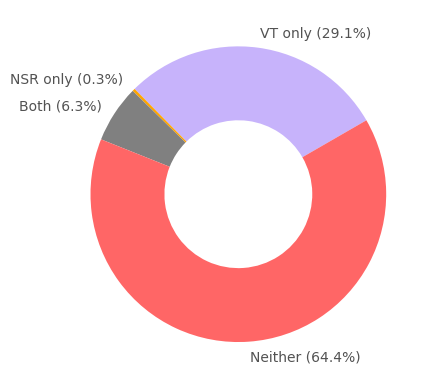

In [31]:
def create_pie_chart():
    data = create_total_stats()
    stats = data.sum()
    nsr_only = (stats["NSR_only"]/stats["Total"]) * 100
    v_only =  (stats["Velocity_only"]/stats["Total"]) * 100
    both = (stats["Both"]/stats["Total"]) * 100
    neither = (stats["Neither"]/stats["Total"]) * 100
    labels = [f"VT only ({v_only:.1f}%)", 
              f"NSR only ({nsr_only:.1f}%)",
              f"Both ({both:.1f}%)",
              f"Neither ({neither:.1f}%)"]
    y = np.array([v_only, nsr_only, both, neither])
    font_color = '#525252'
    colors = ['#c7b3fb', 'orange', 'grey', '#ff6666'] # change color both or neither 

    fig ,ax = plt.subplots()
    ax.pie(y, 
           labels= labels,
           startangle=30, 
           wedgeprops=dict(width=.5), # For donuts
           colors=colors, 
           textprops={'color':font_color},
           pctdistance=0.8,
           )
create_pie_chart()

In [32]:
def get_train_test(type, data, drops = None):
    if data == "VT":
        pb = VELOCITY_PLOT_PROBS.copy()
        suffix = "v"
    if data == "NSR":
        pb = NSR_PLOT_PROBS.copy()
        suffix = "nsr"
    v_probs = pb.groupby("site",as_index=False).agg({
                                                        "lat":"median",
                                                        "lon":"median", 
                                                        f"num_pf_{suffix}":"sum",
                                                        "num_event":"sum",
                                                        "num_event_growing": "sum",
                                                        "num_pf_growing": "sum", 
                                                        "num_event_non_growing": "sum", 
                                                        "num_pf_non_growing": "sum",
                                                        "NPP":"median",
                                                        "GPP":"median",
                                                        "ET":"median",
                                                        "MAT":"median",
                                                        "MAP":"median",
                                                        "aridity":"median",
                                                        "sand":"median",
                                                        "silt":"median",
                                                        "clay":"median",
                                                        "canopy":"median",
                                                        "site_storm_intensity":"median",
                                                        "site_storm_intensity_growing": "median", 
                                                        "site_storm_intensity_non_growing": "median",
                                                        "landcover": lambda x: x.unique()[0]})
    v_probs["p_total"] = v_probs[f"num_pf_{suffix}"]/v_probs["num_event"]
    v_probs["p_growing"] = v_probs["num_pf_growing"]/v_probs["num_event_growing"]
    v_probs["p_non_growing"] = v_probs["num_pf_non_growing"]/v_probs["num_event_non_growing"]
    v_probs = v_probs.drop(columns=[f"num_pf_{suffix}","num_event", "num_pf_non_growing","num_event_non_growing",
                                    "num_pf_growing","num_event_growing", "site",
                                     "lat", "lon", "silt"]).copy()
    
    if drops is not None:
        v_probs = v_probs.drop(columns=drops)
    if type == "all":
        total_data = v_probs.drop(columns = ["p_growing", "p_non_growing",  
                                             "site_storm_intensity_growing", 
                                            "site_storm_intensity_non_growing"]).copy().dropna()
        print(total_data.shape)
        # total_data = total_data[total_data["p_total"]>0].copy()
        y = total_data["p_total"]
        x = total_data.drop("p_total", axis = 1)
        
    if type == "growing":
        total_data = v_probs.drop(columns = ["p_total", "p_non_growing",  
                                             "site_storm_intensity", 
                                            "site_storm_intensity_non_growing"]).copy().dropna()
        total_data = total_data[total_data["p_growing"]>0].copy()
        y = total_data["p_growing"]
        x = total_data.drop("p_growing", axis = 1)
            
    if type == "non_growing":
        total_data = v_probs.drop(columns = ["p_total", "p_growing",  
                                             "site_storm_intensity", 
                                            "site_storm_intensity_growing"]).copy().dropna()
        total_data = total_data[total_data["p_non_growing"]>0].copy()
        y = total_data["p_non_growing"]
        x = total_data.drop("p_non_growing", axis = 1)
        

    x =  pd.get_dummies(x, columns= ["landcover"], dtype=int)
    
 
    return train_test_split(x, y, test_size=.4, random_state=42)

X_train_vt_t, X_test_vt_t, y_train_vt_t, y_test_vt_t = get_train_test("all", "VT", ["GPP"])     

X_train_nsr_t, X_test_nsr_t, y_train_nsr_t, y_test_nsr_t = get_train_test("all", "NSR", ["GPP"])        


(40, 11)
(40, 11)


/Users/bonanli/opt/anaconda3/envs/NEON_PF_database/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
/Users/bonanli/opt/anaconda3/envs/NEON_PF_database/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


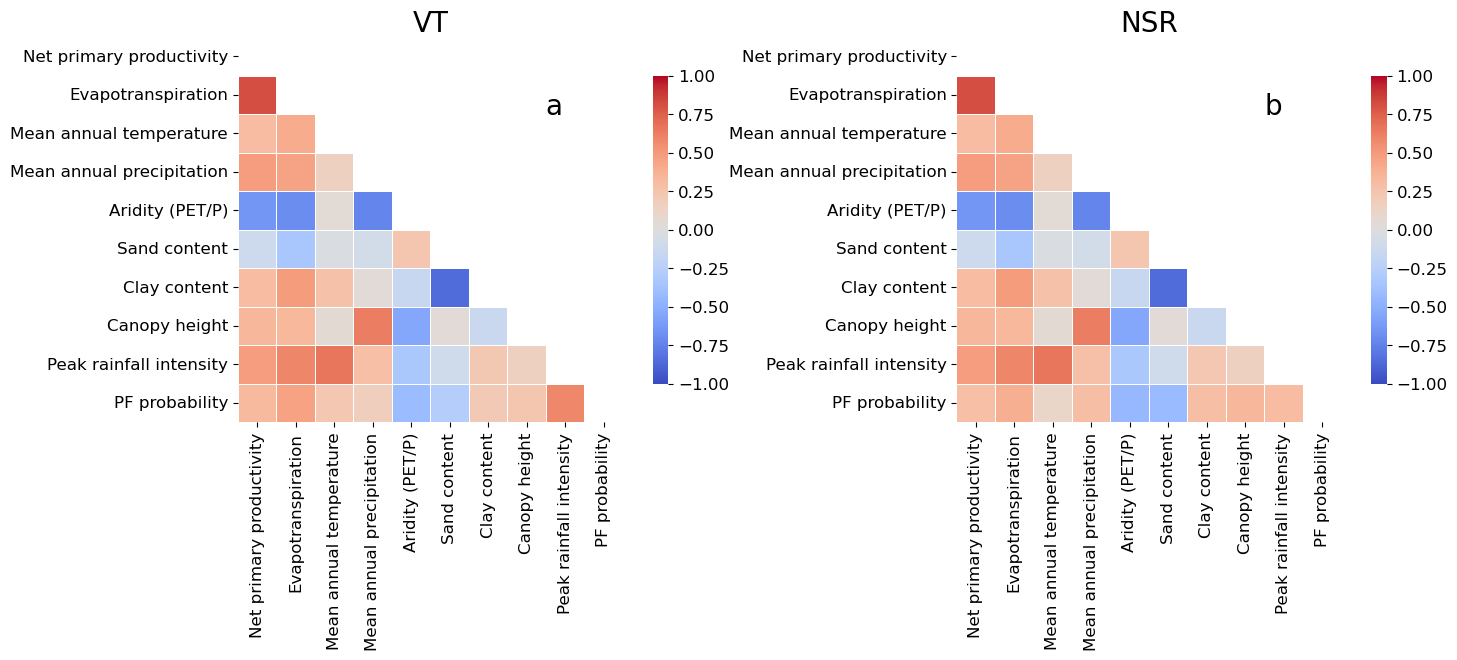

In [33]:
def create_correlate():
    import seaborn as sns
    fig, ax = plt.subplots(1,2,figsize  = (17, 5))
    corr_vt_pre = pd.concat([X_train_vt_t, X_test_vt_t])
    corr_vt_tar = pd.concat([y_train_vt_t, y_test_vt_t])
    corr_nsr_pre = pd.concat([X_train_nsr_t, X_test_nsr_t])
    corr_nsr_tar = pd.concat([y_train_nsr_t, y_test_nsr_t])
    vt_all = pd.concat([corr_vt_pre, corr_vt_tar], axis=1)
    nsr_all = pd.concat([corr_nsr_pre, corr_nsr_tar], axis=1)
    index_mapping = {'landcover_Grassland': 'Grassland', 'landcover_Mixed Grassland': 'Mixed grassland',
                     "landcover_Shrubland": "Shrubland", "canopy":"Canopy height", 
                     "landcover_Mixed Forest": "Mixed forest",
                     "landcover_Cropland":"Cropland",
                     "MAP": "Mean annual precipitation",
                     "ET":"Evapotranspiration", "MAT": "Mean annual temperature", 
                     "aridity": "Aridity (PET/P)", "sand": "Sand content",
                     "landcover_Forest":"Forest", "clay":"Clay content",
                     "NPP": "Net primary productivity",
                     "site_storm_intensity": "Peak rainfall intensity",
                     "p_total": "PF probability"} 
    vt_all = vt_all.rename(columns=index_mapping).drop(columns=['Grassland', 'Mixed grassland',
                                                                "Shrubland", "Mixed forest","Cropland",
                                                               "Forest",])
    nsr_all = nsr_all.rename(columns=index_mapping).drop(columns=['Grassland', 'Mixed grassland',
                                                                "Shrubland", "Mixed forest", "Cropland",
                                                               "Forest",])
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(vt_all.corr(), dtype=bool))

    mask2 = np.triu(np.ones_like(nsr_all.corr(), dtype=bool))
    sns.heatmap(vt_all.corr(), mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
                cbar_kws={"shrink": .8}, square=True, linewidths=.5, ax = ax[0], vmin=-1, vmax=1)
    sns.heatmap(nsr_all.corr(), mask=mask2, annot=True, fmt=".2f", cmap='coolwarm',
                cbar_kws={"shrink": .8}, square=True, linewidths=.5, ax = ax[1], vmin=-1, vmax=1)
    ax[0].tick_params("both", labelsize = 12)
    ax[1].tick_params("both", labelsize = 12)
    ax[0].text(0.8,0.8, "a", fontsize = 20, transform = ax[0].transAxes )
    ax[1].text(0.8,0.8, "b", fontsize = 20, transform = ax[1].transAxes )
    ax[0].set_title("VT", fontsize = 20, transform = ax[0].transAxes )
    ax[1].set_title("NSR", fontsize = 20, transform = ax[1].transAxes )
    for cax in [ax[0].collections[0].colorbar.ax, ax[1].collections[0].colorbar.ax]:
        cax.tick_params(labelsize=12)
create_correlate()

In [34]:
def fit_ML_models(X:pd.DataFrame, y:pd.DataFrame):
    """fit the random forest model.
    Args:
        X (_type_): _description_
        y (_type_): _description_

    Returns:
        _type_: _description_
    """
    param_rf = {
        'n_estimators': [10, 50, 100, 300, 500],  # Number of trees
        'min_samples_split':[2, 3, 4],  # Minimum samples required to split an internal node
        'min_samples_leaf': [1, 2, 3],  # Minimum samples required to be at a leaf node
        'max_features': ["log2"],
        "max_depth":[None, 3, 5, 7, 10]
    }
    random_forest =  RandomForestRegressor(random_state=42)
    gcv_rf = GridSearchCV(random_forest, param_grid = param_rf, cv = 3, n_jobs=15, scoring="neg_mean_squared_error")
            
    return  gcv_rf.fit(X,y)

vt_fit_t = fit_ML_models(X_train_vt_t, y_train_vt_t)
# vt_fit_grw = fit_ML_models(X_train_vt_grw, y_train_vt_grw)
# vt_fit_ngw = fit_ML_models(X_train_vt_ngw, y_train_vt_ngw)

nsr_fit_t = fit_ML_models(X_train_nsr_t, y_train_nsr_t)
# nsr_fit_grw = fit_ML_models(X_train_nsr_grw, y_train_nsr_grw)
# nsr_fit_ngw = fit_ML_models(X_train_nsr_ngw, y_train_nsr_ngw)


In [35]:
def get_rf_model(X,y, model):
    results = permutation_importance(model.best_estimator_, X, y, n_repeats= 500, random_state=42, scoring= "r2")
    print(model.best_estimator_.get_params())
    feature_df = pd.DataFrame({"Feature":X.columns.to_numpy(), 
                                "Importance score":results.importances_mean})
    feature_df = feature_df.sort_values(by='Importance score', ascending=True)
    index_mapping = {'landcover_Grassland': 'Grassland', 'landcover_Mixed Grassland': 'Mixed grassland',
                     "landcover_Shrubland": "Shrubland", "canopy":"Canopy height", 
                     "landcover_Mixed Forest": "Mixed forest",
                     "landcover_Cropland":"Cropland",
                     "MAP": "Mean annual precipitation",
                     "ET":"Evapotranspiration", "MAT": "Mean annual temperature", 
                     "aridity": "Aridity (PET/P)", "sand": "Sand content",
                     "landcover_Forest":"Forest", "clay":"Clay content",
                     "NPP": "Net primary productivity",
                     "site_storm_intensity": "Peak rainfall intensity"} 
    feature_df = feature_df.set_index('Feature')
    feature_df = feature_df.rename(index=index_mapping)
    best_model = model.best_estimator_
    # print(model_output.get_params())
    # Make predictions on the validation set 
    y_pred = best_model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return {"model":best_model, "yhat":y_pred, "ytrue":y , "r2": r2, "rmse":rmse, "importance":feature_df,
            "model_param":model.best_params_}

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
0.8424191536337403 0.49306489209479565 0.05801136569321484 0.09868167442880366
0.8308843232766652 0.29292565899820877 0.01834960282016086 0.05605113214062457


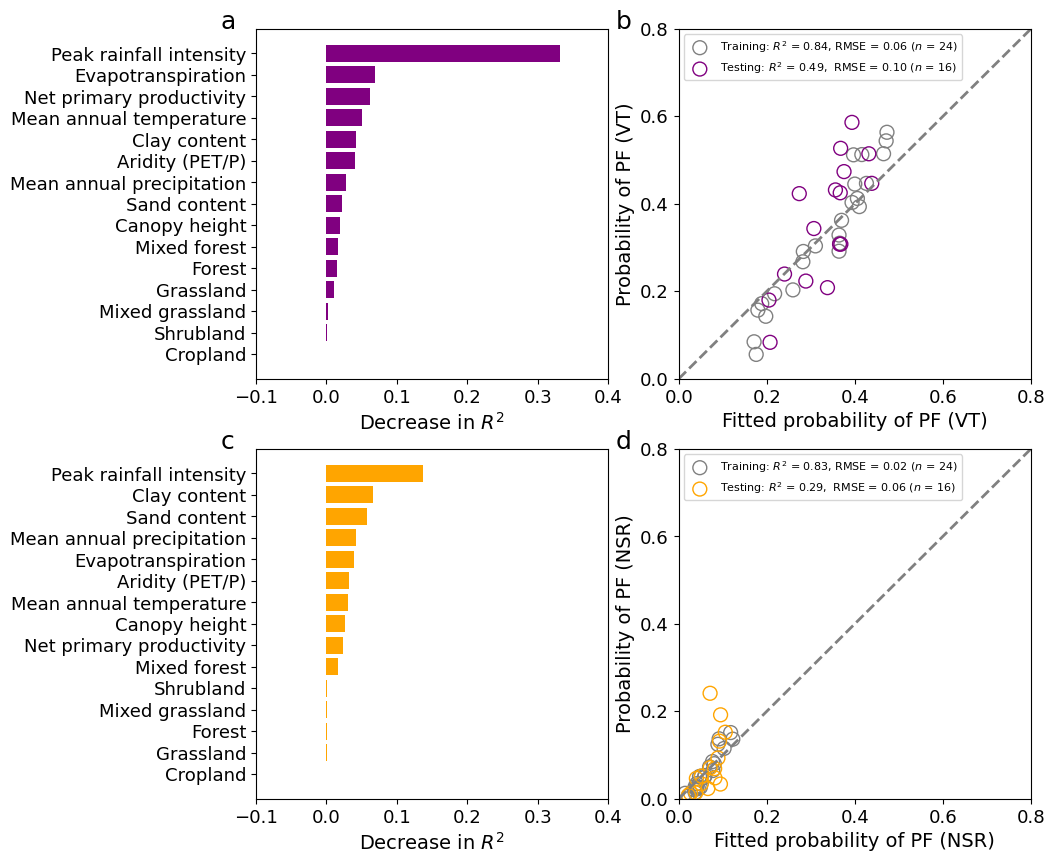

In [36]:
def plot_feature_importance(vt_info = None, nsr_info= None, total_if = True):
    fig, ax = plt.subplots(2, 2, figsize = (10,10))
    if total_if:
        VT_rf = get_rf_model(pd.concat([vt_info["X_train"], vt_info["X_test"]]), 
                             pd.concat([vt_info["y_train"], vt_info["y_test"]]), 
                             vt_info["model"])
        NSR_rf = get_rf_model(pd.concat([nsr_info["X_train"], nsr_info["X_test"]]),
                              pd.concat([nsr_info["y_train"], nsr_info["y_test"]]),
                              nsr_info["model"])
    else:
        VT_rf = get_rf_model(vt_info["X_test"], vt_info["y_test"], vt_info["model"])
        NSR_rf = get_rf_model(nsr_info["X_test"], nsr_info["y_test"], nsr_info["model"])
    hub = [VT_rf, NSR_rf]
    training_info = [vt_info, nsr_info]
    labels = ["VT", "NSR"]
    colors = ["purple", "orange"]
    num = [["a","b"], ["c", "d"]]
    for i in range(2):
        data = hub[i]
        info_i = training_info[i]
        # get the training R2
        pred_train = info_i["model"].best_estimator_.predict(info_i["X_train"])
        pred_test = info_i["model"].best_estimator_.predict(info_i["X_test"])
        r2_train = r2_score(info_i["y_train"], pred_train)
        r2_test = r2_score(info_i["y_test"], pred_test) 
        rmse_train =  np.sqrt(mean_squared_error(info_i["y_train"], pred_train))
        rmse_test = np.sqrt(mean_squared_error(info_i["y_test"], pred_test))
        print(r2_train, r2_test, rmse_train, rmse_test)
        ax[i, 0].barh(data["importance"].index, data["importance"]['Importance score'], color=colors[i])
        ax[i, 1].scatter(pred_train, info_i["y_train"], s = 100,
                         edgecolor = "grey", facecolor = "none", label = f"Training: $R^2$ = {r2_train:.2f}, RMSE = {rmse_train:.2f} ($n$ = {pred_train.shape[0]})")
        ax[i, 1].scatter(pred_test, info_i["y_test"], s = 100,
                         edgecolor = colors[i], facecolor = "none", label = f"Testing: $R^2$ = {r2_test:.2f},  RMSE = {rmse_test:.2f} ($n$ = {pred_test.shape[0]})")
        ax[i, 1].set_xlim([0, 0.8])
        ax[i, 1].set_ylim([0, 0.8])
        ax[i, 1].plot([0, 0.8], [0, 0.8], c= "grey", ls = "dashed", lw = 2)
        ax[i, 1].xaxis.set_major_locator(plt.MaxNLocator(5))
        ax[i, 1].xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

        ax[i, 1].yaxis.set_major_locator(plt.MaxNLocator(5))
        ax[i, 1].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
        ax[i, 0].tick_params("both", labelsize = 13)  
        ax[i, 1].tick_params("both", labelsize = 13)  
        ax[i, 0].set_xlim([-0.1, 0.4])
        ax[i, 1].set_xlabel(f"Fitted probability of PF ({labels[i]})",fontsize = 14)
        ax[i, 1].set_ylabel(f"Probability of PF ({labels[i]})", fontsize = 14)
        ax[i, 0].text(-0.1, 1, num[i][0], transform = ax[i, 0].transAxes,
                      fontsize = 18)
        ax[i, 1].text(-0.18,1, num[i][1], transform = ax[i, 1].transAxes,
                      fontsize = 18)
        ax[i, 1].legend(fontsize = 8)
        ax[i, 0].set_xlabel("Decrease in $R^2$", fontsize = 14)
        # plt.tight_layout(pad=1)

plot_feature_importance({"X_test":X_test_vt_t, "y_test":y_test_vt_t, "model":vt_fit_t, "X_train":X_train_vt_t, "y_train":y_train_vt_t},
                        {"X_test":X_test_nsr_t, "y_test":y_test_nsr_t, "model":nsr_fit_t, "X_train":X_train_nsr_t, "y_train":y_train_nsr_t},
                        total_if=True)


In [37]:
def compute_partial_dependence(model, 
                               X, 
                               features, 
                               grid_resolution=100):
    pdp_list = []
    grid_list = []
    for f in features:
        values = np.linspace(X[f].min(), X[f].max(), grid_resolution)
        pdp = np.zeros(grid_resolution)
        X_temp = X.copy()
        for i, val in enumerate(values):
            X_temp[f] = val
            pdp[i] = model.predict(X_temp).mean()
        pdp_list.append(pdp)
        grid_list.append(values)
    return grid_list, pdp_list

In [38]:
def get_color(name, size,  reverse=False):
    cmap = plt.get_cmap(name)
    if size > 2:
        thresholds = [0.1, 0.5, 0.8]
    else:
        thresholds = [0.2, 0.7]
    if reverse:
        thresholds = thresholds[::-1]
    colors = [cmap(i) for i in thresholds]
    return colors


/Users/bonanli/opt/anaconda3/envs/NEON_PF_database/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bonanli/opt/anaconda3/envs/NEON_PF_database/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bonanli/opt/anaconda3/envs/NEON_PF_database/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bonanli/opt/anaconda3/envs/NEON_PF_database/lib/python3.11/site-packages/seaborn/_ol

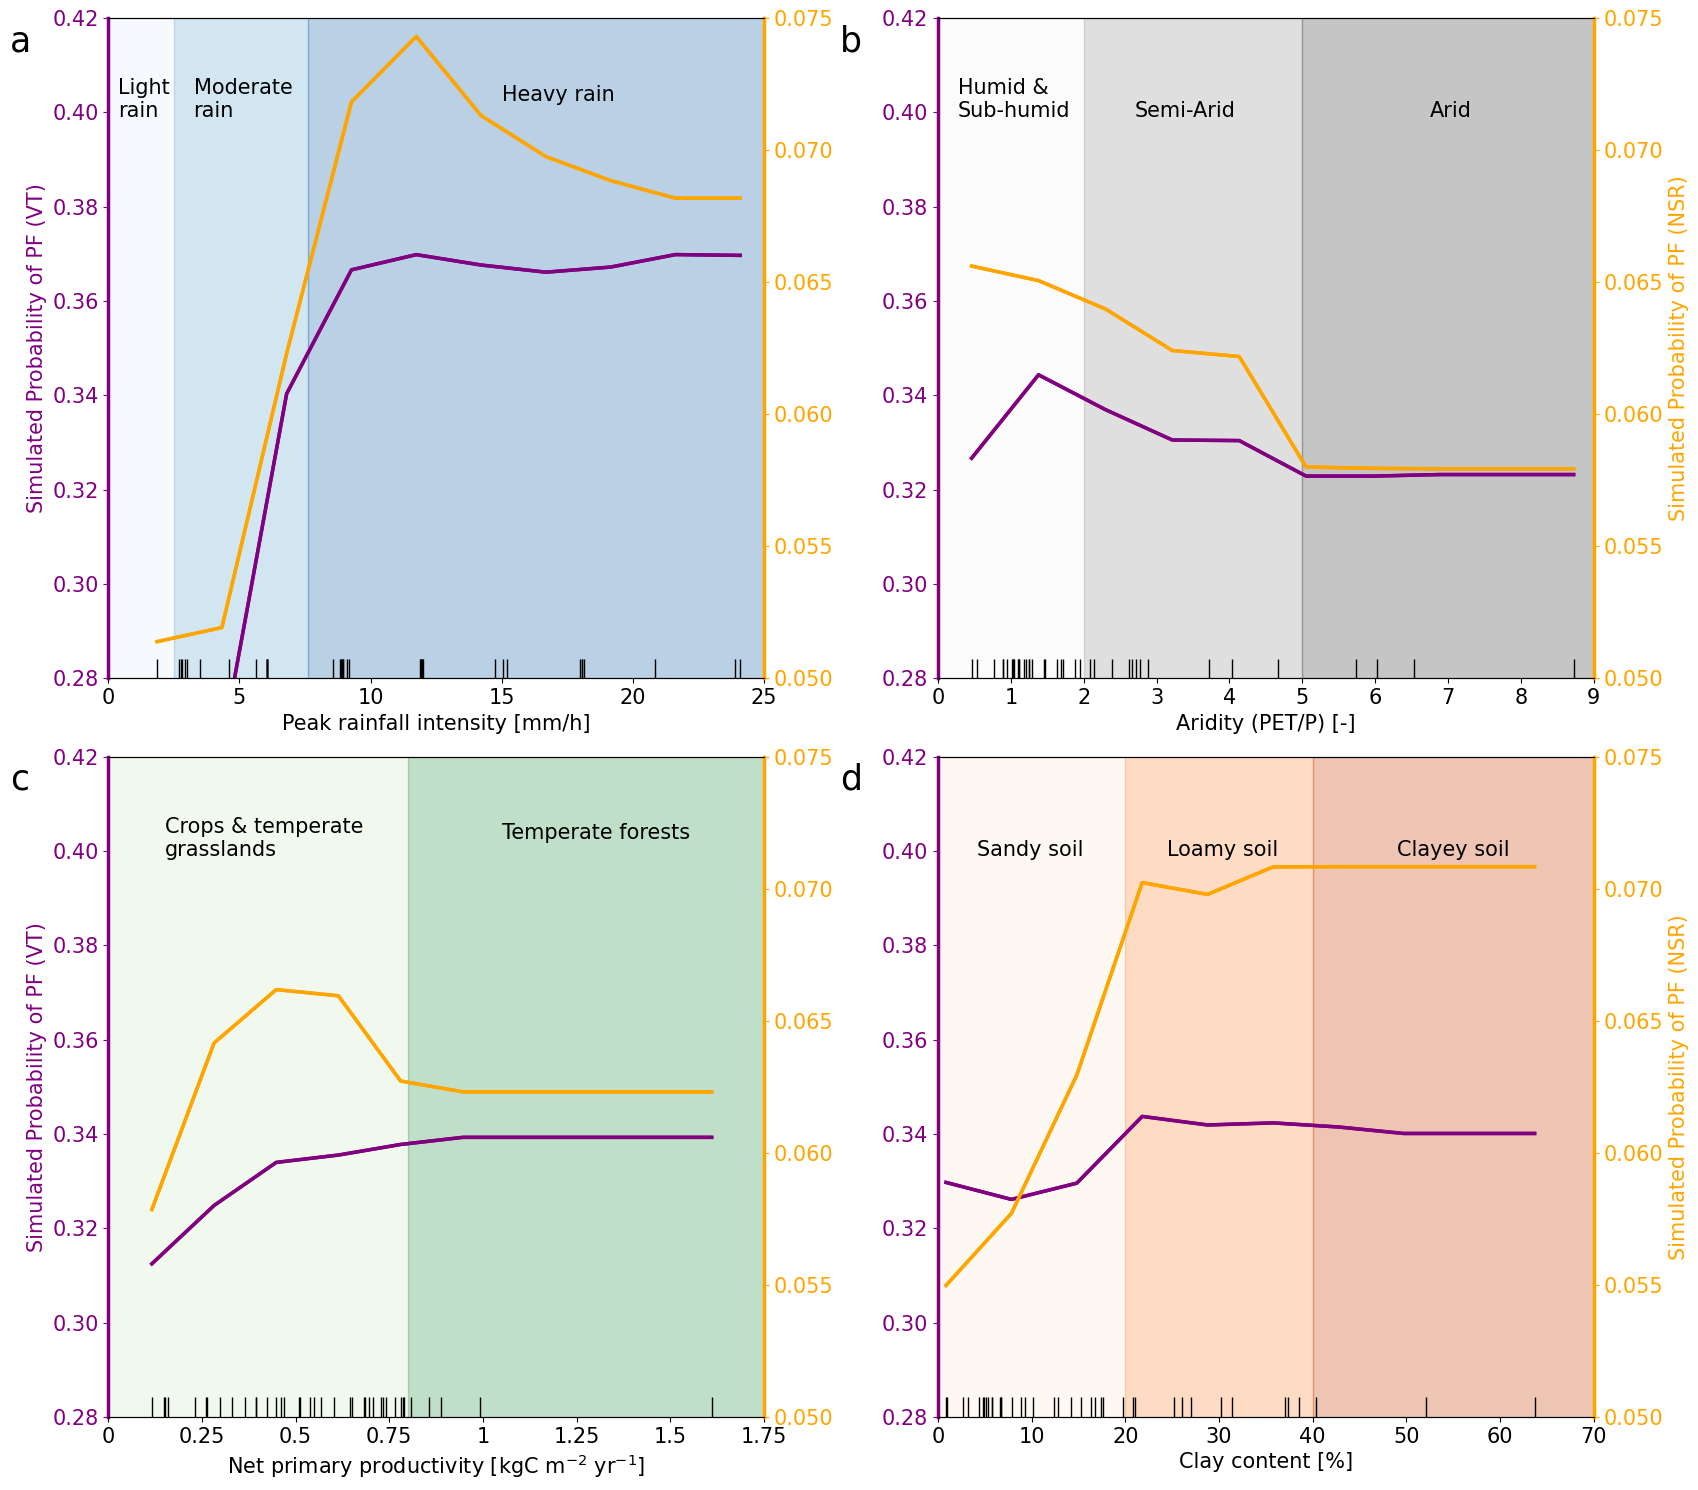

In [39]:
def plot_pdp(pdp_vt_info:dict, pdp_nsr_info:dict, features:list[str]) ->None:
    """get partial dependence plot

    Args:
        pdp_vt_info (dict): VT traing,testing, model info.
        pdp_nsr_info (dict): VT traing,testing, model info.
        features (list[str]): list of features to plot [4 elements].
    """

    vt_data = pd.concat([pdp_vt_info["train_X"], pdp_vt_info["test_X"]])
    nsr_data = pd.concat([pdp_nsr_info["train_X"], pdp_nsr_info["test_X"]])
    plt_vt_data = vt_data.copy()
    pdp_vt = compute_partial_dependence(pdp_vt_info["model"].best_estimator_, vt_data, features, 10)
    plt_vt_data["site_storm_intensity"] = plt_vt_data["site_storm_intensity"] * 6
    
    plt_nsr_data = nsr_data.copy()
    pdp_nsr = compute_partial_dependence(pdp_nsr_info["model"].best_estimator_, nsr_data, features, 10)
    plt_nsr_data["site_storm_intensity"] = plt_nsr_data["site_storm_intensity"] * 6

    fig, ax = plt.subplots(2, 2, figsize= (17, 15))
    style_dict = dict(
        site_storm_intensity=dict(
            shade_threshold=[(0, 2.5), (2.5, 7.6), (7.6, 100)],
            xlim=[0, 25],
            tickx= [0, 5, 10, 15, 20, 25],
            cate_labels =  [[0.015, 0.85], [0.13, 0.85], [0.6, 0.875]],
            threshold_labels = ["Light\nrain", "Moderate\nrain", "Heavy rain"],
            c= get_color("Blues", 3),
            x_label="Peak rainfall intensity [mm/h]"
        ),
        NPP=dict(
            shade_threshold= [(0, 0.8), (0.8, 20)],
            xlim=[0, 1.75],
            tickx=[0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75],
            cate_labels =[[0.15/1.75, 0.85], [0.6, 0.875]],
            threshold_labels= ["Crops & temperate\ngrasslands", "Temperate forests"],
            c= get_color("Greens",2),
            x_label="Net primary productivity [kgC m$^{-2}$ yr$^{-1}]$"
        ),
        clay=dict(
            shade_threshold= [(0, 20), (20, 40), [40, 100]],
            xlim=[0, 70],
            tickx= [0, 10, 20, 30, 40 , 50, 60, 70],
            cate_labels =[[0.06, 0.85], [0.35, 0.85], [0.7, 0.85]],
            threshold_labels= ["Sandy soil", "Loamy soil", "Clayey soil"],
            c=get_color("Oranges",3),
            x_label="Clay content [%]"
            ),
        aridity=dict(
            shade_threshold=[(0, 2), (2, 5), (5, 100)] ,
            xlim=[0, 9],
            tickx= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
            cate_labels = [[0.03, 0.85], [0.3, 0.85], [0.75, 0.85]],
            threshold_labels= ["Humid &\nSub-humid", "Semi-Arid","Arid"],
            c=get_color("Greys",3),
            x_label="Aridity (PET/P) [-]"
        )
    )

    nums = ["a", "b", "c", "d"]
    for i in np.arange(len(features)):
        row = i // 2 
        col = i % 2
        # get necessary variables
        var_name = features[i]
        color = style_dict[var_name]["c"]
        vt_grid = pdp_vt[0][i]
        nsr_grid = pdp_nsr[0][i]
        feature_threshold = style_dict[var_name]["shade_threshold"]
        thresh_labels =  style_dict[var_name]["threshold_labels"]
        thresh_label_loc=  style_dict[var_name]["cate_labels"]
        x_label = style_dict[var_name]["x_label"]
        #
        if var_name == "site_storm_intensity":
            vt_grid = vt_grid * 6
            nsr_grid = nsr_grid * 6
        anotherx = ax[row, col].twinx()
        ax[row, col].set_xlabel(x_label, fontsize = 15)
        ax[row, col].tick_params(axis='y', colors='purple', direction='out')
        ax[row, col].tick_params("both", direction='out', labelsize = 15)
        anotherx.spines['left'].set_color('purple')
        anotherx.spines['right'].set_color('orange')  
        if i in [1,3]:
            anotherx.set_ylabel("Simulated Probability of PF (NSR)", fontsize = 15, c= "orange")
        anotherx.tick_params(axis='both', direction='out', labelsize= 15)
        anotherx.tick_params(axis='y', colors='orange', direction='out')

        ax[row, col].plot(vt_grid, pdp_vt[1][i], c = "purple", lw = 2.5)
        anotherx.plot(nsr_grid, pdp_nsr[1][i], c = "orange", lw = 2.5)
        anotherx.spines['left'].set_linewidth(2.5) 
        anotherx.spines['right'].set_linewidth(2.5)

            
      
        # ax[0, i].tick_params("both", labelsize = 15)
        # ax[1, i].tick_params("both", labelsize = 15)
        sns.rugplot(plt_vt_data[features[i]] , ax=ax[row, col], color='black', height=.03)

        for th in np.arange(len(feature_threshold)):
            ax[row, col].fill_between(feature_threshold[th],
                                      y1 = 0, y2 = 1, color= color[th], alpha = 0.3)
            ax[row, col].text(thresh_label_loc[th][0],
                         thresh_label_loc[th][1],
                         thresh_labels[th],
                         transform = ax[row, col].transAxes, 
                         fontsize = 15)
        if i not in [1,3]:
            ax[row, col].set_ylabel("Simulated Probability of PF (VT)", fontsize = 15, c= "purple")
        ax[row, col].tick_params(axis='y', colors='purple', direction='out')
        ax[row, col].tick_params("both", direction='out', labelsize = 15)
        anotherx.spines['left'].set_color('purple')
        anotherx.spines['right'].set_color('orange')  
        # anotherx.set_ylabel("Simulated Probability of PF (NSR)", fontsize = 15, c= "orange")
        anotherx.tick_params(axis='both', direction='out', labelsize= 15)
        anotherx.tick_params(axis='y', colors='orange', direction='out')

        ax[row, col].plot(vt_grid, pdp_vt[1][i], c = "purple", lw = 2.5)
        anotherx.plot(nsr_grid, pdp_nsr[1][i], c = "orange", lw = 2.5)
        anotherx.spines['left'].set_linewidth(2.5) 
        anotherx.spines['right'].set_linewidth(2.5)
    

        ax[row, col].text(-0.15, 0.95, nums[i], transform = ax[row, col].transAxes,
                      fontsize = 25)

        anotherx.set_ylim(0.05, 0.075)
        ax[row, col].set_ylim(0.28, 0.42)
        ax[row, col].set_xlim(style_dict[var_name]["xlim"][0],style_dict[var_name]["xlim"][1])
        ax[row, col].set_xticks(style_dict[var_name]["tickx"])
        ax[row, col].set_xticklabels([str(val) for val in style_dict[var_name]["tickx"]])


    plt.tight_layout()

plot_pdp({"test_X":X_test_vt_t,
          "train_X":X_train_vt_t,
          "model":vt_fit_t},
         {"test_X":X_test_nsr_t,
          "train_X":X_train_nsr_t,
          "model":nsr_fit_t}, ["site_storm_intensity", "aridity", "NPP", "clay",])

[[1.         0.58858261]
 [0.58858261 1.        ]]


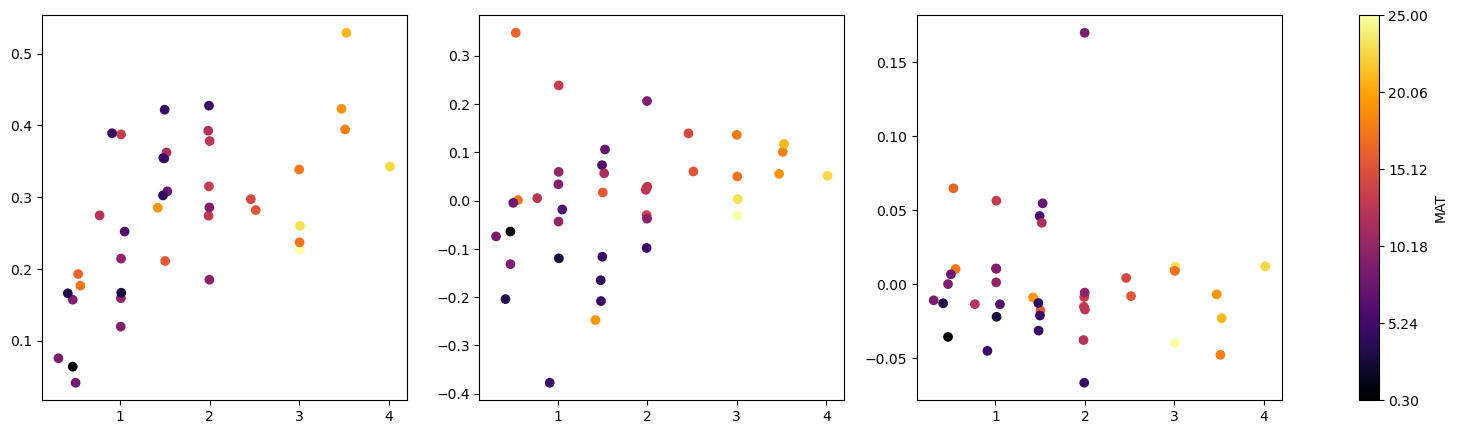

In [40]:
def plot_nsr_vt(color_by, c):
    v_probs = VELOCITY_PLOT_PROBS.groupby("site",as_index=False).agg({
                                                    "num_pf_v":"sum",
                                                    "num_event":"sum",
                                                    "num_event_growing": "sum",
                                                    "num_pf_growing": "sum", 
                                                    "num_event_non_growing": "sum", 
                                                    "num_pf_non_growing": "sum",
                                                    "full_season_intensity":"median",
                                                    "growing_season_intensity":"median",
                                                    "non_growing_season_intensity":"median",
                                                    "MAP": "median",
                                                    "MAT": "median",
                                                    "aridity":"median"})
    
    v_probs["p_total_v"] = v_probs[f"num_pf_v"]/v_probs["num_event"]
    v_probs["p_growing_v"] = v_probs["num_pf_growing"]/v_probs["num_event_growing"]
    v_probs["p_non_growing_v"] = v_probs["num_pf_non_growing"]/v_probs["num_event_non_growing"]
    
    nsr_probs = NSR_PLOT_PROBS.groupby("site",as_index=False).agg({
                                                    "num_pf_nsr":"sum",
                                                    "num_event":"sum",
                                                    "num_event_growing": "sum",
                                                    "num_pf_growing": "sum", 
                                                    "num_event_non_growing": "sum", 
                                                    "num_pf_non_growing": "sum"})
    nsr_probs["p_total_nsr"] = nsr_probs[f"num_pf_nsr"]/nsr_probs["num_event"]
    nsr_probs["p_growing_nsr"] = nsr_probs["num_pf_growing"]/nsr_probs["num_event_growing"]
    nsr_probs["p_non_growing_nsr"] = nsr_probs["num_pf_non_growing"]/nsr_probs["num_event_non_growing"]
    data = pd.merge(v_probs[["site", "p_total_v","p_growing_v", "p_non_growing_v", "MAP", "MAT", "aridity", "full_season_intensity",
                             "growing_season_intensity", "non_growing_season_intensity"]]
                    , nsr_probs[["site", "p_total_nsr","p_growing_nsr", "p_non_growing_nsr"]], on = "site", how = "outer")
    fig, ax = plt.subplots(1,3, figsize=(20,5))
    import matplotlib as mpl
    if color_by == "aridity":
        data["aridity"] = np.log(data["aridity"])
    s1 = ax[0].scatter(data[color_by], data["p_total_v"] - data["p_total_nsr"], c = data[c],cmap = "inferno")
    print(np.corrcoef(data[color_by], data["p_total_v"] - data["p_total_nsr"]))
    # ax[0].plot([0, 0.65], [0, 0.65])
    # ax[0].tick_params("both", labelsize = 15)
    # ax[0].set_xlabel("Probability of NSR", fontsize =15)
    # ax[0].set_ylabel("Probability of VT", fontsize =15)
    s2 = ax[1].scatter(data[color_by], data["p_non_growing_v"] - data["p_growing_v"], c = data[c],cmap = "inferno")
    # ax[1].plot([0, 0.9], [0, 0.9])
    # ax[1].tick_params("both", labelsize = 15)
    # ax[1].set_xlabel("Probability of VT (growing)", fontsize =15)
    # ax[1].set_ylabel("Probability of VT (non-growing)", fontsize =15)
    s3 = ax[2].scatter(data[color_by], data["p_non_growing_nsr"]-  data["p_growing_nsr"], c = data[c],cmap = "inferno") 
    # ax[2].plot([0, 0.5], [0, 0.5])
    # ax[2].tick_params("both", labelsize = 15)
    # ax[2].set_xlabel("Probability of NSR (growing)", fontsize =15)
    # ax[2].set_ylabel("Probability of NSR (non-growing)", fontsize =15)
    norm = mpl.colors.Normalize(vmin=data[c].min(), vmax=data[c].max())  # Or customize your normalization
    cbar = plt.colorbar(s3, ax=ax.ravel().tolist(), orientation='vertical', ticks = np.linspace(norm.vmin, norm.vmax, 6), norm=norm)
    cbar.set_label(c)
plot_nsr_vt("full_season_intensity", "MAT")
    

In [41]:
def save_table(save_table = False):
    nsr_stats = NSR_PLOT_PROBS.groupby("site",as_index=False).agg({
                                                        "lat": "median",
                                                        "lon":"median",
                                                        "landcover":lambda x: x.unique()[0],
                                                        "MAT":"median",
                                                        "MAP":"median",
                                                        "aridity":"median",
                                                        "num_pf_nsr":"sum",})
    vs_stats = VELOCITY_PLOT_PROBS.groupby("site",as_index=False).agg({
                                                        "num_pf_v":"sum",})
    table = pd.merge(nsr_stats, vs_stats, on = "site")

    table.columns = ["Site name", "Lat.", "Lon.", "Landcover", "MAT (°C)", "MAP (mm)", "Aridity (PET/P)", "Num. NSR PF", "Num. VT PF"]
    table[["Ecoregion", "State"]] = table["Site name"].apply(lambda x: pd.Series(get_ecoregion(x)))
    if save_table:
        table.to_csv("table.csv", index=False)
save_table(False)

In [42]:
def move_loc(row):
    name = row["site"]
    lat = row["lat"]
    lon = row["lon"]
    dx = 0
    dy = 0
    if name == "ABBY":
        dy = 1.5
        dx = - 0.8
    elif name == "WREF":
        dy = 1.5
        dx = 1.5
    elif name == "DCFS":
        dy = -2.5
    elif name == "WOOD":
        dx = 3
    elif name == "LAJA":
        dy = 2
        dx = -2
    elif name == "GUAN":
        dy = 1.5
        dx = 1
    elif name == "SCBI":
        dy = 1
        dx = -2.5
    elif name =="BLAN":
        dy = 2
        dx = 0.8
    elif name == "ORNL":
        dy = 2
        dx = -1
    elif name == "GRSM":
        dy = -0.5
        dx = 2
    elif name == "NIWO":
        dy = -2
        dx = 1
    elif name == "RMNP":
        dy = 1
        dx = -2
    elif name == "SJER":
        dy = 2
        dx = -1.8
    elif name == "SOAP":
        dy = 1.8
        dx = 1
    elif name == "TEAK":
        dy = -2
        dx = 1.5
    elif name == "TALL":
        dy = 1.5
        dx = -0.5
    elif name == "DELA":
        dy = 0.5
        dx = -2.2
    elif name == "LENO":
        dy = -0.8
        dx = -2
    return (lat + dy, lon + dx, dy, dx)

0.0 0.24124513618677043
0.05580357142857143 0.5861618798955613
[[ 1.         -0.58858261]
 [-0.58858261  1.        ]]


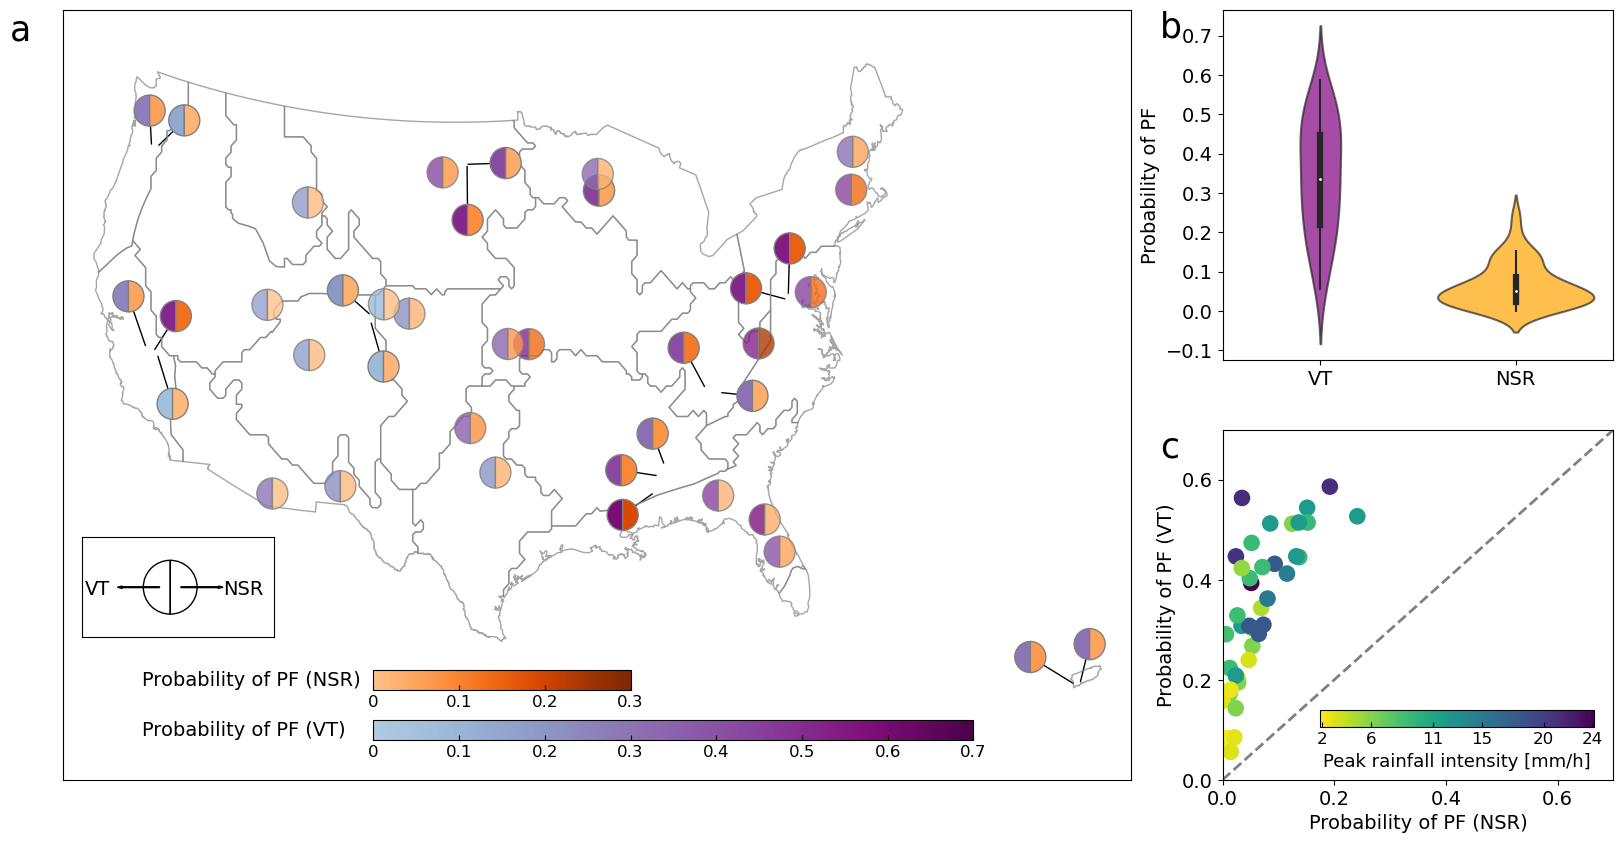

In [54]:
def nature_geo_fg1(cmaps):
    exclude = ["ABBY", "WREF", "DCFS", "WOOD", "LAJA", "GUAN", "SCBI", "BLAN", "ORNL", "GRSM", "NIWO", "RMNP", "SJER", "SOAP", "TEAK", "TALL", "DELA", "LENO"]

    shp_file = gpd.read_file("../../../NEONDomains_0/NEON_Domains.shp")
    nsr_probs = NSR_PLOT_PROBS.groupby("site",as_index=False).agg({
                                                    "lat":"median",
                                                    "lon":"median", 
                                                    "num_pf_nsr":"sum",
                                                    "num_event":"sum",
                                                    })
    velocity_probs = VELOCITY_PLOT_PROBS.groupby("site", as_index=False).agg({
                                                    "lat":"median",
                                                    "lon":"median", 
                                                    "num_pf_v":"sum",
                                                    "num_event":"sum",
                                                    "full_season_intensity":"median"})

    nsr_probs["p_nsr"] = nsr_probs["num_pf_nsr"]/nsr_probs["num_event"]
    velocity_probs["p_v"] = velocity_probs["num_pf_v"]/velocity_probs["num_event"]
    merge_all_gpd = pd.merge(nsr_probs.drop(columns=["lat", "lon"]), 
                            velocity_probs, on ="site", how = "inner")
    merge_all_gpd[["lat_new", "lon_new", "dy", "dx"]] = merge_all_gpd.apply(move_loc, axis  = 1, result_type="expand")

    g1 = merge_all_gpd[~merge_all_gpd["site"].isin(exclude)].copy()
    gdf = gpd.GeoDataFrame(g1, geometry=gpd.points_from_xy(g1.lon_new, g1.lat_new))
    gdf.crs = "EPSG:4326"
    gdf = gdf.to_crs("EPSG:2163")

    g2 = merge_all_gpd[merge_all_gpd["site"].isin(exclude)].copy()
    gdf2 = gpd.GeoDataFrame(g2, geometry=gpd.points_from_xy(g2.lon_new, g2.lat_new))
    gdf2.crs = "EPSG:4326"
    gdf2 = gdf2.to_crs("EPSG:2163")

    shp_file = shp_file.to_crs("EPSG:2163")# Plot your Shapefile and the field sites
    
    from matplotlib.gridspec import GridSpec 
    # create subplots
    fig = plt.figure(figsize = (20, 10))
    gs = GridSpec(2, 3, figure=fig, width_ratios= [1, 2, 1.2], height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[:, :2]) # spatial plots
    ax3 = fig.add_subplot(gs[0, -1]) # scatter with colored by storm intensity
    ax2 = fig.add_subplot(gs[1, -1]) # boxplot

    
    shp_file.boundary.plot(ax=ax1, linewidth=1,edgecolor ="grey", alpha = 0.7)
    
    norm_nsr = Normalize(vmin=0,
                         vmax=.3)
    norm_v = Normalize(vmin=0,
                       vmax=.7)
    print(merge_all_gpd["p_nsr"].min(),merge_all_gpd["p_nsr"].max())
    print(merge_all_gpd["p_v"].min(),merge_all_gpd["p_v"].max())
    
    def adjust_colormap(cmap_name, minval=0.0, maxval=1.0, n=100):
        import matplotlib.colors as mcolors
        cmap = plt.get_cmap(cmap_name)
        new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'adjusted({n},{a:.2f},{b:.2f})'.format(n=cmap_name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
        return new_cmap

    adj_cmap_vt = adjust_colormap(cmaps["VT"], 0.3, 1)
    
    sm1 = ScalarMappable(cmap=adj_cmap_vt, norm=norm_v)
    sm1.set_array([])  # Dummy data to create the ScalarMappable     

    gdf.plot(ax=ax1, markersize=500, cmap = adj_cmap_vt,
                    zorder=20, legend=False, column="p_v",
                    edgecolor="grey", alpha=0.8,norm = norm_v,
                    marker=MarkerStyle("o", fillstyle="left"),
                    legend_kwds={
                        "shrink": 0.7,
                        
                    })

    adj_cmap_nsr = adjust_colormap(cmaps["NSR"], 0.3, 1)
    sm2 = ScalarMappable(cmap=adj_cmap_nsr, norm=norm_nsr)
    sm2.set_array([])  # Dummy data to create the ScalarMappable    
    gdf.plot(ax=ax1, markersize=500, cmap=adj_cmap_nsr,
                        zorder=20, legend=False, column="p_nsr",
                        edgecolor="grey", alpha=0.8,norm = norm_nsr,
                        marker=MarkerStyle("o", fillstyle="right"),
                        legend_kwds={
                            "shrink": 0.4,
                            "pad":-0.15,
                            # "orientation":"horizontal",
                            "location":"bottom",
                            "anchor": (.3,1)
                            
                        })

    gdf2.plot(ax=ax1, markersize=500, cmap = adj_cmap_vt,
                    zorder=20, legend=False, column="p_v",
                    edgecolor="grey", alpha= 1,norm = norm_v,
                    marker=MarkerStyle("o", fillstyle="left"),
                    legend_kwds={
                        "shrink": 0.7,
                        
                    })


        
    gdf2.plot(ax=ax1, markersize=500, cmap=adj_cmap_nsr,
                        zorder=20, legend=False, column="p_nsr",
                        edgecolor="grey", alpha=1,norm = norm_nsr,
                        marker=MarkerStyle("o", fillstyle="right"),
                        legend_kwds={
                            "shrink": 0.4,
                            "pad":-0.15,
                            # "orientation":"horizontal",
                            "location":"bottom",
                            "anchor": (.3,1)
                            
                        })

    ax1.set_xlim([-2.2*1e6, 3.8*1e6])
    ax1.set_ylim([-2.8*1e6, 1*1e6])
    ax1.set_aspect('auto', adjustable=None)

    # Assuming you have your GeoDataFrame 'gdf' and the map 'ax' already defined

    for _, ar in gdf2.iterrows():
        if ar["dy"] != 0 or ar["dx"] != 0:       
            
            arrow_start = Point(ar["lon"], ar["lat"])
            arrow_end = Point(ar["lon_new"], ar["lat_new"])

            # Convert Point geometries to GeoDataFrame for coordinate transformation
            arrow_start_series = gpd.GeoSeries([arrow_start], crs="EPSG:4326")
            arrow_end_series = gpd.GeoSeries([arrow_end], crs="EPSG:4326")

            # Transform arrow coordinates to EPSG:2163
            arrow_start_transformed = arrow_start_series.to_crs("EPSG:2163").geometry.iloc[0]
            arrow_end_transformed = arrow_end_series.to_crs("EPSG:2163").geometry.iloc[0]


           # Create and add arrow to the plot
            arrow = FancyArrowPatch(
                posA= ( arrow_start_transformed.x,arrow_start_transformed.y),
                posB=(arrow_end_transformed.x, arrow_end_transformed.y),
                mutation_scale=15,
                arrowstyle="->",
                facecolor="black",
                edgecolor="black"
            )
            ax1.add_patch(arrow)


    ax1.set_xticks([])
    ax1.set_yticks([])
    
    sm_vt = plt.cm.ScalarMappable(cmap=adj_cmap_vt, norm=norm_v)
    sm_vt._A = []  # Fake up the array of the scalar mappable
    cbar = fig.colorbar(sm_vt, ax=ax1, orientation="horizontal", fraction=0.05, pad=0.05,
                     cax=fig.add_axes([0.28, .15, 0.3, 0.02]))  # Adjust the position and size of the colorbar
    tick_positions = [0, .1, .2, .3, .4, .5, .6, .7]
    tick_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7']
    cbar.ax.set_xticks(tick_positions)
    cbar.ax.set_xticklabels(tick_labels)
    cbar.ax.tick_params(labelsize=12, direction = "in")
    cbar.ax.text(-0.27,0.2, "Probability of PF (VT)", fontsize = 14)
    
    sm_nsr = plt.cm.ScalarMappable(cmap=adj_cmap_nsr, norm=norm_nsr)
    sm_nsr._A = []  # Fake up the array of the scalar mappable
    cbar_nsr = fig.colorbar(sm_nsr, ax=ax1, orientation="horizontal", fraction=0.05, pad=0.05,
                     cax=fig.add_axes([0.28, .2, 0.3 * 3 / 7, 0.02]))  # Adjust the position and size of the colorbar
    tick_positions_nsr = [0, 0.1, 0.2, 0.3]
    tick_labels_nsr = ['0', '0.1', '0.2', '0.3']
    cbar_nsr.ax.set_xticks(tick_positions_nsr)
    cbar_nsr.ax.set_xticklabels(tick_labels_nsr)
    cbar_nsr.ax.tick_params(labelsize=12, direction = "in")
    cbar_nsr.ax.text(-0.27,0.2, "Probability of PF (NSR)", fontsize = 14)

    ax_legend = ax1.inset_axes([0.017, 0.185, 0.18, 0.13])

    ax_legend.set_xticks([])
    ax_legend.set_yticks([])
    ax_legend.scatter(0.1,0.25,s = 1500, transform = ax1.transAxes,
            edgecolor="black",  facecolor = "none",
            marker=MarkerStyle("o", fillstyle="left"),)
    ax_legend.scatter(0.1,0.25,s = 1500, transform = ax1.transAxes,
            edgecolor="black",  facecolor = "none",
            marker=MarkerStyle("o", fillstyle="right"),)
    ax_legend.arrow(0.09, 0.25, -0.035, 0,transform = ax1.transAxes)
    ax_legend.arrow(0.11, 0.25, 0.035, 0,transform = ax1.transAxes)
    ax_legend.text(0.09 - 0.07, 0.24, "VT", transform = ax1.transAxes, fontsize  = 14)
    ax_legend.text(0.11 + 0.04, 0.24, "NSR",transform = ax1.transAxes, fontsize = 14)

    
    scatter = ax2.scatter(merge_all_gpd["p_nsr"], merge_all_gpd["p_v"],
                      c=merge_all_gpd["full_season_intensity"] * 6,
                      cmap="viridis_r", s=120)
    print(np.corrcoef(merge_all_gpd["p_nsr"] - merge_all_gpd["p_v"], merge_all_gpd["full_season_intensity"] * 6))
    norm_scatter = Normalize(vmin=merge_all_gpd["full_season_intensity"].min() * 6,
                         vmax=merge_all_gpd["full_season_intensity"].max() * 6)

    # Create an inset axes within the subplot for the colorbar
    cax = ax2.inset_axes([0.25, 0.15, 0.7, 0.05])  # [left, bottom, width, height] in relative coordinates to ax2

    cbar_scatter = plt.colorbar(scatter, cax=cax, orientation='horizontal',
                            ticks=[round(i) for i in np.linspace(norm_scatter.vmin, norm_scatter.vmax, 6)],
                            norm=norm_scatter)
    cbar_scatter.set_label("Peak rainfall intensity [mm/h]", fontsize=13)
    cbar_scatter.ax.tick_params(labelsize=12, direction = "in")
    ax2.set_xlim([0, 0.7])
    ax2.set_ylim([0, 0.7])
    num_ticks = 4

    # Set the locator and formatter for the x-axis
    ax2.xaxis.set_major_locator(plt.MaxNLocator(num_ticks))
    ax2.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

    # Set the locator and formatter for the y-axis
    ax2.yaxis.set_major_locator(plt.MaxNLocator(num_ticks))
    ax2.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))   
    ax2.tick_params("both",labelsize = 14)
    ax2.plot([0,1], [0,1], ls = "dashed", lw = 2, c= "grey")
    ax2.set_xlabel("Probability of PF (NSR)", fontsize = 14)
    ax2.set_ylabel("Probability of PF (VT)", fontsize = 14)
    
    # ax3.boxplot(merge_all_gpd[["p_v", "p_nsr"]],
    #             widths=0.25,          # Set the width of the boxes
    #             patch_artist=True,  # Enable filling the boxes with colors
    #             boxprops=dict(facecolor='none', color='black', lw = 1.5),  # Set properties of the boxes
    #             whiskerprops=dict(lw = 1.5),  # Set properties of the whiskers
    #             capprops=dict(lw = 1.5),    # Set properties of the caps
    #             medianprops=dict(color='red', lw= 2)  # Set properties of the median lines
    #             )
    vo_plot = sns.violinplot(data=merge_all_gpd[["p_v", "p_nsr"]], 
                             palette= ["Purple", "Orange"], inner="box", ax = ax3,
                   linewidth=1.5)
    from matplotlib.collections import PolyCollection

    for i, patch in enumerate(vo_plot.findobj(PolyCollection)):
       
        if i % 2 == 0:  # Even indexed patches are violins
            patch.set_facecolor("Purple")  # Set face color for Column1
            patch.set_alpha(0.7)
        else:
            patch.set_facecolor("Orange")  # Set face color for Column2
            patch.set_alpha(0.7)  # Set transparency (alpha) to 0.7

    ax3.set_ylabel("Probability of PF", fontsize = 14)
    ax3.set_xticklabels(["VT", "NSR"],fontsize = 14)
    ax3.tick_params("both", labelsize=14)
    ax1.text(-0.05, 0.96, 'a', transform=ax1.transAxes, fontsize = 25)
    ax2.text(-0.16, 0.92, 'c', transform=ax2.transAxes, fontsize = 25)
    ax3.text(-0.16, 0.92, 'b', transform=ax3.transAxes, fontsize = 25)

nature_geo_fg1(dict(VT= "BuPu", NSR="Oranges"))

In [ ]:
def nature_geo_sup2():
    col = ["aridity", "MAT", "MAP", "mean_storm_intensity"]
    xaxis = ["Aridity (PET/P)",  "Mean annual temperature (°C)","Mean annual precipitation (mm)", "Median storm intensity (mm/10min)"]
    fig_num = ["a", "b", "c", "d"]
    non_sequential_pf = NSR_PLOT_PROBS[NSR_PLOT_PROBS["p_pf_nsr"] >0].copy()
    velocity_pf = VELOCITY_PLOT_PROBS[VELOCITY_PLOT_PROBS["p_pf_v"] >0].copy()
    fig, ax = plt.subplots(2,2, figsize = (10,10))
    for s in np.arange(len(col)):
        row_num = s//2
        col_num = s%2  

        if col[s] == "mean_storm_intensity":
            matrix_nsr = non_sequential_pf[["median_storm_intensity_nsr","p_pf_nsr"]].dropna()
            matrix_v = velocity_pf[["median_storm_intensity_v","p_pf_v"]].dropna()
            r_nsr, p_nsr = stats.pearsonr(matrix_nsr["median_storm_intensity_nsr"], matrix_nsr["p_pf_nsr"])
            r_v, p_nsr = stats.pearsonr(matrix_v["median_storm_intensity_v"], matrix_v["p_pf_v"])
            
            ax[row_num, col_num].scatter(non_sequential_pf["median_storm_intensity_nsr"], non_sequential_pf["p_pf_nsr"], 
                        label = f"NSR, $r$={r_nsr:.2f}", c = "green",
                        s = 100, zorder = 20, alpha = 0.8)
            ax[row_num, col_num].scatter(velocity_pf["median_storm_intensity_v"], velocity_pf["p_pf_v"], 
                        label = f"VT, $r$={r_v:.2f}",s = 100 ,alpha = 0.8, c = "red")
        else:
            r_nsr = non_sequential_pf[[col[s],"p_pf_nsr"]].corr().iloc[0, 1]
            r_v = velocity_pf[[col[s],"p_pf_v"]].dropna().corr().iloc[0, 1]
            
            ax[row_num, col_num].scatter(non_sequential_pf[col[s]], non_sequential_pf["p_pf_nsr"], 
                        label = f"NSR, $r$ = {r_nsr:.2f}",c = "green",alpha = 0.8,
                        s = 100, zorder = 20)
            ax[row_num, col_num].scatter(velocity_pf[col[s]], velocity_pf["p_pf_v"], 
                        label = f"VT, $r$ = {r_v:.2f}",s = 100 ,alpha = 0.8, c = "red")
            
        ax[row_num, col_num].legend(loc = "upper right", fontsize = 12)
        ax[row_num, col_num].tick_params("both", labelsize = 14)
        ax[row_num, col_num].set_xlabel(xaxis[s], fontsize = 15)
        if s == 0 or s == 2: 
            ax[row_num, col_num].set_ylabel("Probability of PF occurence", fontsize =16)
        ax[row_num, col_num].text(0.1, 0.8, fig_num[s], transform = ax[row_num, col_num].transAxes, fontsize = 20)
        ax[row_num, col_num].set_ylim([0, 1])
# nature_geo_sup2()

In [ ]:
shp_file = gpd.read_file("../../../NEONDomains_0/NEON_Domains.shp")

In [ ]:
def nature_geo_sup2_soil_texture():
    xaxis = ["Sand (%)", "Silt (%)", "Clay (%)", 
           "Porosity (-)", "Effective porosity (-)",  "Log(root density) [g/m$^3$]"]
    col = ["surface_sand", "surface_silt","surface_clay","porosity", "eff_porosity", "log_root_density"]
    fig_num = ["a", "b", "c", "d", "e", "f"]
    non_sequential_pf =NSR_PLOT_PROBS[NSR_PLOT_PROBS["p_pf_nsr"] >0].copy()
    print(non_sequential_pf["p_pf_nsr"].describe())
    non_sequential_pf["log_root_density"] = np.log(non_sequential_pf["surface_root_density"])
    velocity_pf = VELOCITY_PLOT_PROBS[VELOCITY_PLOT_PROBS["p_pf_v"] >0].copy()
    print(velocity_pf["p_pf_v"].describe())
    velocity_pf["log_root_density"] = np.log(velocity_pf["root_density"])
    fig, ax = plt.subplots(2,3, figsize = (15,10))
    for s in np.arange(len(col)):
        row_num = s//3
        col_num = s%3 
        nsr_matrix =  non_sequential_pf[[col[s], "p_pf_nsr"]].dropna()
        v_matrix = velocity_pf[[col[s], "p_pf_v"]].dropna()
        r_nsr, p_nsr = stats.pearsonr(nsr_matrix[col[s]].to_numpy(), nsr_matrix["p_pf_nsr"].to_numpy())
        r_v, p_v = stats.pearsonr(v_matrix[col[s]].to_numpy(), v_matrix["p_pf_v"].to_numpy())
        ax[row_num, col_num].scatter(non_sequential_pf[col[s]], non_sequential_pf["p_pf_nsr"], 
                    label = f"NSR, $r$={r_nsr:.2f}",c = "green",alpha = 0.8,
                    s = 100, zorder = 20)
        ax[row_num, col_num].scatter(velocity_pf[col[s]], velocity_pf["p_pf_v"], 
                    label = f"VT, $r$ = {r_v:.2f}",s = 100 ,alpha = 0.8, c = "red")
            
        ax[row_num, col_num].legend(loc = "upper right", fontsize = 12)
        ax[row_num, col_num].tick_params("both", labelsize = 14)
        ax[row_num, col_num].set_xlabel(xaxis[s], fontsize = 15)
        if s == 0 or s == 3: 
            ax[row_num, col_num].set_ylabel("Probability of PF occurence", fontsize =16)
        ax[row_num, col_num].text(0.1, 0.8, fig_num[s], transform = ax[row_num, col_num].transAxes, fontsize = 20)
        ax[row_num, col_num].set_ylim([0, .8])
# nature_geo_sup2_soil_texture()

In [ ]:
def get_nsr_bin(bin_by, bin_num = 20):
    """calculate probability of PF by binning.

    Args:
        bin_by (str): "stormPeakIntensity" or "surface_sm"
        bin_num (int, optional): number of bins. Defaults to 20.

    Returns:
        pd.DataFrame: regression slopes.
    """
    if bin_by == "surface_sm":
        final_name = "sm"
        extracted = "stormPeakIntensity"
        name = "peak_intensity"
    if bin_by == "stormPeakIntensity":
        final_name = "peak_intensity"
        extracted = "surface_sm"
        name = "soil_moisture"
    nsr_info_slope = []
    overall = {}
    for nsr_site in GAP_FILLED_SM.keys(): 
        site_nsr =  GAP_FILLED_SM[nsr_site]
        site_specific = []
        if len(site_nsr) > 0 and nsr_site not in EXCLUDED_SITE:
            for i in site_nsr:  
                plot_data = i.copy()
                if not plot_data.empty:
                    expand_texture = ["surface_sand", "surface_silt", "surface_clay", "surface_porosity",
                                      "surface_eff_porosity", "surface_root_density"]
                    plot_data[expand_texture] = plot_data.apply(depth_weight_soil_param, axis = 1, result_type="expand")
                    surface_soil_texture = plot_data[expand_texture].median()
                    get_h_pos = [i for i in plot_data.columns if "nake" in i]
                    unique_h_pos = plot_data[get_h_pos[0]].unique()[0].split("_")[0]
                    plot_data["surface_sm"]= plot_data.apply(get_depth_wegithed, args=(nsr_site, ), result_type= "expand", axis = 1)
                    plot_data["month"] = plot_data["stormStartTime"].dt.month
                    plot_data["season"] = plot_data["month"].apply(lambda x: "dry" if 4 <= x <= 9 else "wet")
                    # do the binning, performance regression, keep the onse with surface sm 
                    plot_data = plot_data[plot_data["surface_sm"].notnull()].copy()
                    # not we are on pedon scale. 
                    global_min = plot_data[bin_by].min()
                    global_max = plot_data[bin_by].max()
                    regress_data = []
                    _, bin_edges = np.histogram(plot_data[bin_by], bins=bin_num, range= (global_min, global_max))
                    bin_intervals =  [[bin_edges[bi], bin_edges[bi + 1]] for bi in np.arange(len(bin_edges)-1)]
                    for it in np.arange(len(bin_intervals)):
                        lower_bound = bin_intervals[it][0]
                        upper_bound = bin_intervals[it][1]
                        mid_point = (upper_bound + lower_bound)/2
                        conditions =  (lower_bound <= plot_data[bin_by]) & (plot_data[bin_by] < upper_bound)
                        if it == len(bin_intervals):
                            conditions =  (lower_bound <= plot_data[bin_by]) & (plot_data[bin_by] <= upper_bound)
                        bin_specific = plot_data.loc[conditions, :].copy()
                        num_pf = bin_specific.loc[bin_specific["flowTypes"] == 'nonSequentialFlow', :].shape[0]
                        # dry season PF
                        dry_PF = bin_specific.loc[(bin_specific["flowTypes"] =='nonSequentialFlow') &
                                                      (bin_specific["season"] == "dry"), :]
                        # wet season PF
                        wet_PF = bin_specific.loc[(bin_specific["flowTypes"] =='nonSequentialFlow') &
                                                      (bin_specific["season"] == "wet"), :]
                        # dry season total events
                        dry_total =  bin_specific[bin_specific["season"] == "dry"]
                        # wet season total events 
                        wet_total = bin_specific[bin_specific["season"] == "wet"]
                        if num_pf > 0:
                            percent  = num_pf/bin_specific.shape[0]
                            # total PF
                            x_axis_PF = bin_specific.loc[bin_specific["flowTypes"] == 'nonSequentialFlow',
                                                                bin_by]
                            x_dry = dry_PF[bin_by]
                            x_wet = wet_PF[bin_by]
                            regress_data.append([nsr_site, percent, x_axis_PF.median(), 
                                                 x_dry.median(), x_wet.median(), 
                                                 x_dry.shape[0], x_wet.shape[0],
                                                 dry_total.shape[0], wet_total.shape[0],
                                                 lower_bound, upper_bound, mid_point,
                                                 x_axis_PF, bin_specific[bin_by].tolist(),
                                                 bin_specific.loc[bin_specific["flowTypes"] == 'nonSequentialFlow',extracted].median(),
                                                 x_dry, dry_total[bin_by],    
                                                 dry_PF[extracted].median(),
                                                 x_wet, wet_total[bin_by],
                                                 wet_PF[extracted].median()
                                                 ] + surface_soil_texture.tolist())
                   # now do regression 
                    if len(regress_data) >= 5:
                        rg_data = pd.DataFrame(regress_data, columns= ["site","percent", bin_by, f"{bin_by}_dry", f"{bin_by}_wet",
                                                                       "dry_num_pf", "wet_num_pf", "dry_total", "wet_total",
                                                                        "lower_bound", "upper_bound", "mid_point",
                                                                        f"{bin_by}_{final_name}", f"{bin_by}_{final_name}_npf",extracted,
                                                                        f"{bin_by}_{final_name}_dry", f"{bin_by}_{final_name}_npf_dry", f"{extracted}_dry",
                                                                        f"{bin_by}_{final_name}_wet", f"{bin_by}_{final_name}_npf_wet", f"{extracted}_wet",
                                                                       ] + surface_soil_texture.index.tolist())
                        rg_data["percent_dry"] = rg_data["dry_num_pf"]/rg_data["dry_total"]
                        rg_data["percent_wet"] = rg_data["wet_num_pf"]/rg_data["wet_total"]
                        max_p_total = rg_data.loc[rg_data["percent"].idxmax(), [extracted, "percent"]].tolist()
                        max_id_dry = rg_data["percent_dry"].idxmax()
                        max_id_wet = rg_data["percent_wet"].idxmax()
                        max_p_dry = [np.nan] * 2
                        max_p_wet = [np.nan] * 2
                        if pd.notna(max_id_dry): 
                            max_p_dry = rg_data.loc[max_id_dry, [f"{extracted}_dry", "percent_dry"]].tolist()
                        if pd.notna(max_id_wet):
                            max_p_wet = rg_data.loc[max_id_wet, [ f"{extracted}_wet", "percent_wet"]].tolist()
                        rg_data["log_p"] = np.log(rg_data["percent"])
                        rg_data["log_p_dry"] = np.log(rg_data["percent_dry"])
                        rg_data["log_p_wet"] = np.log(rg_data["percent_wet"])
                        # model fitting y = e^(ax + b) -> log(y) ~ ax + b  
                        # transform 
                        rg_data_total = rg_data.dropna(subset=["log_p", bin_by]).copy()
                        exp_modl = smf.ols(formula=f"log_p ~ {bin_by}", data=rg_data_total)
                        res_exp = exp_modl.fit()
                        exp_modl_info = [res_exp.params[bin_by], res_exp.pvalues[bin_by], res_exp.rsquared, 
                                         r2_score(rg_data_total["percent"], res_exp.fittedvalues)]
                        dry_hub = rg_data.dropna(subset=["log_p_dry", f"{bin_by}_dry"]).copy()  
                        wet_hub  =rg_data.dropna(subset=["log_p_wet", f"{bin_by}_wet"]).copy()

                        dry_hub_info = [np.nan] * 4
                        wet_hub_info = [np.nan] * 4
                        if dry_hub.shape[0] >= 3:
                            exp_modl_dry = smf.ols(formula=f"log_p_dry ~ {bin_by}_dry", data=dry_hub)
                            res_exp_dry = exp_modl_dry.fit()
                            dry_hub_info = [res_exp_dry.params[f"{bin_by}_dry"], res_exp_dry.pvalues[f"{bin_by}_dry"], 
                                            res_exp_dry.rsquared, r2_score(dry_hub["percent_dry"], np.exp(res_exp_dry.fittedvalues))]
                        if wet_hub.shape[0] >= 3:
                            exp_modl_wet = smf.ols(formula=f"log_p_wet ~ {bin_by}_wet", data=wet_hub)
                            res_exp_wet = exp_modl_wet.fit()
                            wet_hub_info = [res_exp_wet.params[f"{bin_by}_wet"], res_exp_wet.pvalues[f"{bin_by}_wet"],
                                            res_exp_wet.rsquared, r2_score(wet_hub["percent_wet"], np.exp(res_exp_wet.fittedvalues)) ]

                        non_reg_info = [
                                        get_aridity(nsr_site), get_site_condition(nsr_site, "MAT"), 
                                        get_site_condition(nsr_site, "MAP"), nsr_site
                                        ] 
                        over_all_nsr = exp_modl_info + dry_hub_info + wet_hub_info + non_reg_info + surface_soil_texture.tolist() + max_p_total + max_p_dry + max_p_wet
                        nsr_info_slope.append(over_all_nsr)
    #                     # site_specific.append(dict(data=rg_data,exp_info=[res_exp.params[bin_by], res_exp.params["Intercept"],
    #                     #                                                  res_exp.pvalues[bin_by], unique_h_pos],
    #                     #     exp_fitted = res_exp.fittedvalues))
        # overall[nsr_site] = site_specific
        
                        
                        
    nsr_info_slope = pd.DataFrame(nsr_info_slope,
                                columns = [
                                            "slope_exp_total", "p_exp_total", "R2_exp_total","R2_exp_norm_total", 
                                            "slope_exp_dry", "p_exp_dry", "R2_exp_dry","R2_exp_norm_dry", 
                                            "slope_exp_wet", "p_exp_wet", "R2_exp_wet","R2_exp_norm_wet", 
                                            "aridity", "MAT", "MAP", "site",
                                            "sand", "silt","clay", "porosity", "eff_porosity","root_density", f"{name}_total"
                                            , "max_p_total",f"{name}_dry"
                                            , "max_p_dry",f"{name}_wet"
                                            , "max_p_wet"])
    return nsr_info_slope, overall
slope_nsr,_ = get_nsr_bin("surface_sm")


In [ ]:
def last_fig(data, type, frac = 0.5):
    
    fig, ax = plt.subplots()
    requried1 = data.loc[:,["max_p_total", "peak_intensity_total"]].copy()
    requried2 = data.loc[:,["max_p_wet", "peak_intensity_wet"]].copy()
    requried3 = data.loc[:,["max_p_dry", "peak_intensity_dry"]].copy()
    datahub = [requried1, requried2, requried3]
    color_c = ["purple", "orange", "green"]
    labels = ["Total", "Growing", "Non-growing"]    
    for i in np.arange(len(datahub)):
        y = [i for i in datahub[i].columns if "max_p_" in i][0]
        x = [i for i in datahub[i].columns if "peak_intensity_" in i][0]
        label = "LOWESS fit"
        if type == "NSR":
            label = f"{labels[i]} LOWESS fit (X ≤ 10)"
            requried = data.loc[data[x] <= 10, [x, y]].copy()
            # ax.axvline(x = 15, c = "black", lw = 3, ls = "dashed", zorder  = 0)
        smoothed = sm.nonparametric.lowess(requried[y].to_numpy(), requried[x].to_numpy(),  frac = frac)

        ax.scatter(data[x], data[y],
                    c = color_c[i], alpha = 0.7, s = 100,
                    )
       
        ax.plot(smoothed[:,0], smoothed[:,1], lw = 6, label = label, c = color_c[i])
        ax.set_xlabel(f"Storm peak intensity [mm/10min]", fontsize = 16)
        ax.tick_params("both", labelsize = 14)
        ax.legend(loc= "upper right", fontsize = 14)
        ax.set_ylabel(f"Maximum probability of PF ({type})",fontsize = 16)

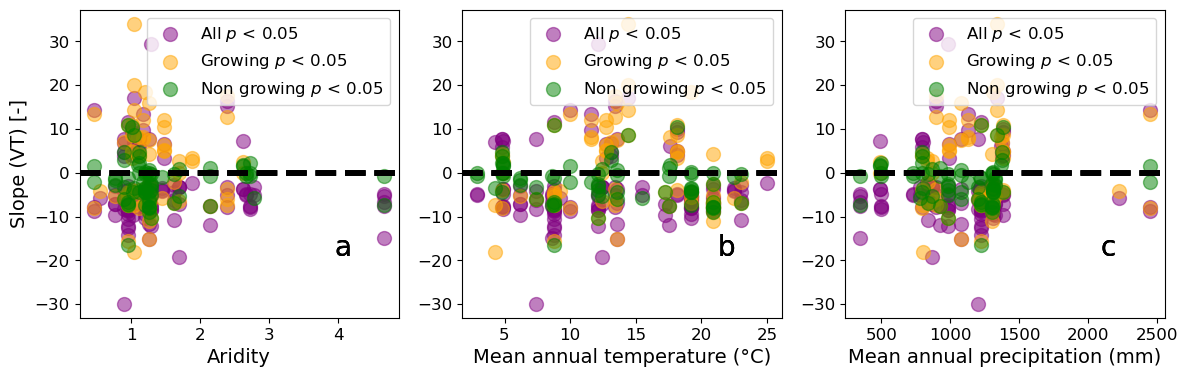

In [47]:
def nature_geo_sup3(data, type):
    fig, ax = plt.subplots(1,3, figsize = (14, 4))
    labels = ["Aridity", "Mean annual temperature (°C)", "Mean annual precipitation (mm)"]
    cols = ["aridity", 'MAT', "MAP"]
    fig_num = ["a", "b", "c"]
    data1 = data.loc[data["p_exp_total"] < 0.05, ["slope_exp_total"] + cols].copy()
    data_wet = data.loc[data["p_exp_wet"] < 0.05, ["slope_exp_wet"] + cols].copy()
    data_dry = data.loc[data["p_exp_dry"] < 0.05,["slope_exp_wet"] + cols].copy()
    datahub = [data1, data_wet, data_dry]
    c = "red"
    if type == "NSR":
        c = "green"
    for i in np.arange(len(labels)):
        color = ["purple", "orange", "green"]
        label = ["All", "Growing", "Non growing"]
        for s in np.arange(len(datahub)):
            yaxes_label = [i for i in datahub[s].columns if "slope_exp_" in i]
            ax[i].scatter(datahub[s][cols[i]],datahub[s][yaxes_label], s = 100, c = color[s],
                        label = f"{label[s]} $p$ < 0.05", alpha = 0.5)
            
            ax[i].tick_params("both", labelsize =12)
            ax[i].set_xlabel(labels[i],fontsize= 14)
            ax[i].tick_params("both", labelsize =12)
            ax[i].text(0.8, 0.2, fig_num[i], transform = ax[i].transAxes, fontsize = 20)
            ax[i].axhline(y = 0, color = "black", ls = "--", lw = 4)
            ax[i].legend(fontsize= 12, loc= "upper right")
            if i == 0:
                ax[i].set_ylabel(f"Slope ({type}) [-]",fontsize= 14)
# nature_geo_sup3(details, "NSR")
nature_geo_sup3(slopes_v, "VT")


In [46]:
def NSR_render(data, type, frac = 0.5):
    data["log_density"] = np.log(data["root_density"])

    labels = ["Sand (%)", "Silt (%)", "Clay (%)", "Porosity (-)", "Effective porosity (-)", "Log(root density) [g/m$^3$]"]
    xes = ["sand", "silt", "clay", "porosity", "eff_porosity", "log_density"]
    data1 = data.loc[data["p_exp_total"] < 0.05, ["slope_exp_total"] + xes].copy()
    data_wet = data.loc[data["p_exp_wet"] < 0.05, ["slope_exp_wet"] + xes].copy()
    data_dry = data.loc[data["p_exp_dry"] < 0.05,["slope_exp_wet"] + xes].copy()
    num_fg = ["a", "b", "c", "d", "e", "f"]
    datahub= [data1, data_wet, data_dry]
    fig, ax = plt.subplots(2,3, figsize=(20,12))
    c = "red"
    if type == "NSR":
        c = "green"
    for j in np.arange(len(num_fg)):
            row, col = j//3, j%3
            param = xes[j]
            color = ["purple", "orange", "green"]
            label = ["Total", "Growing", "Non-growing"]
            for s in np.arange(len(datahub)):
                yaxes_label = [i for i in datahub[s].columns if "slope_exp_" in i]
                
                fit_data = datahub[s][yaxes_label + [param]].dropna().copy()
               
                # transform the data 
                y_axis = StandardScaler().fit_transform(fit_data[yaxes_label].to_numpy().reshape(-1,1))
                lowess =  sm.nonparametric.lowess(fit_data[yaxes_label[0]],fit_data[param].to_numpy(),  frac=frac)
                ax[row, col].axhline(y = 0, c = "black", lw = 3, ls = "dashed", zorder  = 0)
                ax[row, col].scatter(fit_data[param], fit_data[yaxes_label[0]], facecolor = "none", lw =1.5,
                                    s= 200, label = f"{label[s]} $p$ < 0.05", alpha = 0.8, c = color[s])
            
                ax[row, col].plot(lowess[:,0], lowess[:,1], c= color[s], lw = 4, label = "LOWESS fit")

                ax[row,col].set_xlabel(labels[j], fontsize = 20)
                ax[row,col].tick_params("both", labelsize = 16)
                ax[row,0].set_ylabel(f"Slope ({type}) [-]", fontsize = 20)
                ax[row, col].text(0.2, 0.8, num_fg[j], transform = ax[row, col].transAxes, fontsize = 22)
    ax[0,0].legend()
    # ax[0,0].legend(loc = "upper right", fontsize = 18)
# NSR_render(details, "NSR")

In [44]:
def get_v_bin_by_sm():
    sites = FINAL_PF_RESULTS.keys()
    all_site_info = []
    for s in sites: 
        site_data =  FINAL_PF_RESULTS[s]  
        if s not in EXCLUDED_SITE and len(site_data) > 0:
            for plot_data in site_data:  
                if not plot_data.empty:
                    get_h_pos = [i for i in plot_data.columns if "nake" in i]
                    unique_h_pos = plot_data[get_h_pos[0]].unique()[0].split("_")[0]
                    cal_v_cols = [j for j in plot_data.columns if j.split("_")[0] == "velocity"]
                    v_onset = [f"smAtOnset_50{j}" for j in  np.arange(1,len(cal_v_cols) + 1)]
                    v_before = [f"smBeforePrecip_50{j}" for j in  np.arange(1,len(cal_v_cols) + 1)]
                    plot_data[v_onset + v_before] = plot_data[v_onset + v_before].replace(-9999, np.nan)
                    plot_data["month"] = plot_data["stormStartTime"].dt.month
                    plot_data["season"] = plot_data["month"].apply(lambda x: "dry" if 4 <= x <= 9 else "wet")
                    # get the max and min 
                    global_min = plot_data[v_onset].min().min()
                    global_max = plot_data[v_onset].max().max()
                    num_b = 20
                    # sensor specific interval of the events we succesfully extract soil moisture
                    # what fraction of it is 
                    sensor_scale = {}
                    for j in cal_v_cols:
                        # get the sensor ID 
                        ids = j.split("_")[-1]
                        subset_vars = [f"smAtOnset_{ids}", f"sensor_depth_{ids}", f"PF_velocity_metric_{ids}",
                                        f"total_sand_{ids}", f"total_silt_{ids}", f"total_clay_{ids}",
                                        f"total_porosity_{ids}", f"total_eff_porosity_{ids}", f"root_density_{ids}",
                                        "stormPeakIntensity", "season"]
                        soil_vars = [f"sensor_depth_{ids}",  f"total_sand_{ids}",
                                     f"total_silt_{ids}", f"total_clay_{ids}",
                                    f"total_porosity_{ids}", f"total_eff_porosity_{ids}", f"root_density_{ids}"]
                                     
                        data = plot_data[subset_vars].copy()
                        #
                        sup_info = plot_data[soil_vars].median(axis = 0)
                        sup_info_names = ["sensor_depth",  "sand", "silt", "clay",
                                         "porosity", "eff_porosity", "root_density"]
                        # if this is PF velocity
                        data = data[data[f"PF_velocity_metric_{ids}"]].copy()
                        data.columns = ["onset", "sensor_depth", "if_pf", 
                                        "sand", "silt", "clay", "porosity",
                                        "eff_porosity", "root_density",
                                        "storm_peak_intensity", "season"]
                        # either there we have velocity metric or we can extract some data.
                        potential_events_total = plot_data[(plot_data[f"smBeforePrecip_{ids}"].notna()) |
                                                (plot_data[f"smAtOnset_{ids}"].notna())].copy()                                    
                        potential_events_dry = potential_events_total[potential_events_total["season"] == "dry"].copy()
                        potential_events_wet = potential_events_total[potential_events_total["season"] == "wet"].copy()
                        # these peak intensity represent the sensor level total, dry, wet season
                        peak_intensity_total_sensor = data.loc[data["if_pf"], "storm_peak_intensity"].median()
                        peak_intensity_dry_sensor = data.loc[(data["if_pf"]) & (data["season"] == "dry"), "storm_peak_intensity"].median()
                        peak_intensity_wet_sensor = data.loc[(data["if_pf"]) & (data["season"] == "wet"), "storm_peak_intensity"].median()
                        regress_data = []
                        _, bin_edges = np.histogram(data["onset"], bins=num_b, range= (global_min, global_max))
                        bin_intervals =  [[bin_edges[bi], bin_edges[bi + 1]] for bi in np.arange(len(bin_edges)-1)]
                        for it in np.arange(len(bin_intervals)):
                            lower_bound = bin_intervals[it][0]
                            upper_bound = bin_intervals[it][1]
                            mid_point = (upper_bound + lower_bound)/2
                            conditions =  (lower_bound <= data["onset"]) & (data["onset"] < upper_bound)
                            if it == len(bin_intervals):
                                conditions =  (lower_bound <= data["onset"]) & (data["onset"] <= upper_bound)
                            sensor_specific = data[conditions].copy()
                            dry_pf = sensor_specific[sensor_specific["season"] == "dry"].copy()
                            wet_pf = sensor_specific[sensor_specific["season"] == "wet"].copy()
                            if sensor_specific["if_pf"].sum() > 0:
                                percent_total  = sensor_specific["if_pf"].sum()/potential_events_total.shape[0]
                                soil_moisture_total = sensor_specific.loc[sensor_specific["if_pf"], "onset"].median()
                                peak_intensity_total = sensor_specific.loc[sensor_specific["if_pf"], "storm_peak_intensity"].median()
                                
                                peak_intensity_dry = percent_dry = soil_moisture_dry =  np.nan
                                peak_intensity_wet = percent_wet = soil_moisture_wet =  np.nan

                                if dry_pf["if_pf"].sum() > 0:
                                    percent_dry = dry_pf["if_pf"].sum()/potential_events_dry.shape[0]
                                    soil_moisture_dry = dry_pf.loc[dry_pf["if_pf"], "onset"].median()
                                    peak_intensity_dry =  dry_pf.loc[dry_pf["if_pf"], "storm_peak_intensity"].median()
                                if wet_pf["if_pf"].sum() > 0:
                                    percent_wet = wet_pf["if_pf"].sum()/potential_events_wet.shape[0]
                                    soil_moisture_wet = wet_pf.loc[wet_pf["if_pf"], "onset"].median()
                                    peak_intensity_wet =  wet_pf.loc[wet_pf["if_pf"], "storm_peak_intensity"].median()

                                regress_data.append([ 
                                                     percent_total, soil_moisture_total, peak_intensity_total,
                                                     percent_dry, soil_moisture_dry, peak_intensity_dry, 
                                                     percent_wet, soil_moisture_wet, peak_intensity_wet] )
                        if len(regress_data) >= 5:
                            regress_data = pd.DataFrame(regress_data, columns= [
                                                                                "percent_total", "soil_moisture_total", "peak_intensity_total",
                                                                                "percent_dry", "soil_moisture_dry", "peak_intensity_dry",
                                                                                "percent_wet", "soil_moisture_wet", "peak_intensity_wet"
                                                                                 ])
                            def get_regression(season):
                                dt = regress_data.copy()
                                if season in ["dry", "wet"]:
                                    dt = dt[dt[f"percent_{season}"] > 0].copy()
                                    if dt.shape[0] < 3:
                                        return [np.nan] * 6
                                dt["log_p"] = np.log(dt[f"percent_{season}"])
                                max_id = dt[f"percent_{season}"].idxmax()
                                max_p = dt.loc[max_id, [f"peak_intensity_{season}", f"percent_{season}"]].tolist()
                                # model fitting y = e^(ax + b) -> log(y) ~ ax + b  
                                exp_modl = smf.ols(formula=f"log_p ~ soil_moisture_{season}", data=dt)
                                res_exp = exp_modl.fit()
                                normal_space_r2 = r2_score(dt[f"percent_{season}"], np.exp(res_exp.fittedvalues))
                                return  [
                                        res_exp.params[f"soil_moisture_{season}"],
                                        res_exp.pvalues[f"soil_moisture_{season}"],
                                        res_exp.rsquared,
                                        normal_space_r2
                                        ] + max_p
                            non_reg_info = [
                                    get_aridity(s), get_site_condition(s, "MAT"), 
                                    get_site_condition(s, "MAP"), s 
                                    ] 
                            all_site_info.append( get_regression("total") + get_regression("dry") + get_regression("wet") +
                                                 [peak_intensity_total_sensor, peak_intensity_dry_sensor, peak_intensity_wet_sensor]
                                                 +  non_reg_info  + sup_info.tolist())
    all_site_info_pd = pd.DataFrame(all_site_info, columns=[ 
                                                            "slope_exp_total", "p_exp_total", "R2_exp_total","R2_exp_norm_total","peak_intensity_total", "max_p_total",
                                                            "slope_exp_dry", "p_exp_dry", "R2_exp_dry","R2_exp_norm_dry","peak_intensity_dry","max_p_dry",
                                                            "slope_exp_wet", "p_exp_wet", "R2_exp_wet","R2_exp_norm_wet", "peak_intensity_wet","max_p_wet",
                                                            "peak_intensity_sensor_total", "peak_intensity_sensor_dry","peak_intensity_sensor_wet",
                                                            "aridity", "MAT", "MAP", "site"] + sup_info_names 
                                        )
    return all_site_info_pd

In [45]:
slopes_v = get_v_bin_by_sm()

In [ ]:
def nature_geofg4(vt, nsr):
    
    from matplotlib.gridspec import GridSpec 
    # create subplots
    fig = plt.figure(figsize = (12, 10))
    gs = GridSpec(2, 2, figure=fig, width_ratios= [1, 1], height_ratios=[0.7, 1])
    ax1 = fig.add_subplot(gs[0, :]) # spatial plots
    ax2 = fig.add_subplot(gs[1, 0]) # scatter with colored by storm intensity
    ax3 = fig.add_subplot(gs[1, 1]) # boxplot
    vt_sig = vt[vt["p_exp_total"] < 0.05].copy()
    nsr_sg = nsr[nsr["p_exp_total"] < 0.05].copy()
    vt_in_sig = vt[vt["p_exp_total"] >= 0.05].copy()
    nsr_in_sg = nsr[nsr["p_exp_total"] >= 0.05].copy()
    print(f"num of VT is {vt.shape[0]}")
    print(f"num of NSR is {nsr.shape[0]}")
    sns.kdeplot(data=vt_sig["slope_exp_total"].dropna(), ax=ax1, c= "Purple", lw = 3, label="VT ($p$ < 0.05)",)
    sns.kdeplot(data=nsr_sg["slope_exp_total"].dropna(), ax=ax1, c = "Orange", lw = 3, label="NSR ($p$ < 0.05)",)
    ax1.legend(loc = "upper right", fontsize = 15)
    ax1.tick_params("both", labelsize= 15)
    ax1.set_ylabel("Density",fontsize= 15)
    ax1.set_xlabel("Slope of exponential regression", fontsize = 15)
   
    ax2.scatter(vt_in_sig["peak_intensity_sensor_total"] * 6, vt_in_sig["slope_exp_total"], s = 150, 
                label = f"VT ($p$ > 0.05)", alpha = 0.5,edgecolor= "grey", facecolor = "none")
    ax2.scatter(vt_sig["peak_intensity_sensor_total"] * 6, vt_sig["slope_exp_total"], s = 150, 
                label = f"VT ($p$ < 0.05)", edgecolor= "purple", facecolor = "none")
    
    ax3.scatter(nsr_in_sg["peak_intensity_total"] * 6, nsr_in_sg["slope_exp_total"], s = 150, 
                label = f"NSR ($p$ > 0.05)", alpha = 0.5,edgecolor= "grey", facecolor = "none")
    ax3.scatter(nsr_sg["peak_intensity_total"] * 6, nsr_sg["slope_exp_total"], s = 150, 
                label = f"NSR ($p$ < 0.05)", edgecolor= "orange", facecolor = "none")
   
    ax2.legend(loc = "upper right", fontsize = 15)
    ax3.legend(loc = "upper right", fontsize = 15)
    ax2.tick_params("both", labelsize = 15)
    ax3.tick_params("both", labelsize = 15)
    ax2.set_xlabel("Peak rainfall intensity [mm/h]",fontsize = 15)
    ax2.set_ylabel("Exponetial rate coefficent", fontsize = 15)
    ax3.set_xlabel("Peak rainfall intensity [mm/h]",fontsize = 15)
    ax3.set_ylabel("Exponetial rate coefficent", fontsize = 15)
    ax1.text(-0.07, 0.95, 'a', transform=ax1.transAxes, fontsize =25)
    ax2.text(-0.15, 0.95, 'b', transform=ax2.transAxes, fontsize = 25)
    ax3.text(-0.15, 0.95, 'c', transform=ax3.transAxes, fontsize = 25)
nature_geofg4(slopes_v, slope_nsr)    



# sig_p = slopes_v[slopes_v["p_exp_total"] < 0.05]
# sig_p_dry = slopes_v[slopes_v["p_exp_dry"] < 0.05]
# sig_p_wet = slopes_v[slopes_v["p_exp_wet"] < 0.05]
# plt.scatter(sig_p["peak_intensity_sensor_total"],sig_p["slope_exp_total"], s = 150, label = "Total", alpha = 0.8, c= "purple")
# plt.scatter(sig_p_dry["peak_intensity_sensor_dry"],sig_p_dry["slope_exp_dry"],s = 150, label = "Growing season", alpha = 0.8, c= "orange")
# plt.scatter(sig_p_wet["peak_intensity_sensor_wet"],sig_p_wet["slope_exp_wet"], s = 150, label = "Non-growing season", alpha = 0.8, c= "green")
# plt.ylabel("Slope [-]", fontsize =13)
# plt.xlabel("Storm peak intensity (VT)[mm/10min]", fontsize = 13)
# plt.legend(loc= "upper right", fontsize = 12)
# print(sig_p.shape[0], sig_p_dry.shape[0], sig_p_wet.shape[0])

In [48]:
import scipy.interpolate
def smooth(x, y, xgrid, sample_num, frac = 0.5):
    samples = np.random.choice(len(x), sample_num, replace=True)
    y_s = y[samples]
    x_s = x[samples]
    # The returned array is two-dimensional if return_sorted is True, and one dimensional if return_sorted is False. 
    # If return_sorted is True, then a numpy array with two columns. The first column contains the sorted x (exog) values and the second column the associated estimated y (endog) values.
    # If return_sorted is False, then only the fitted values are returned, and the observations will be in the same order as the input arrays
    y_sm = sm.nonparametric.lowess(y_s,x_s, frac=frac, return_sorted = False)
    
    # regularly sample it onto the grid
    y_grid = scipy.interpolate.interp1d(x_s, y_sm, 
                                        fill_value='extrapolate')(xgrid)
    return y_grid

/Users/bonanli/opt/anaconda3/envs/NEON_PF_database/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


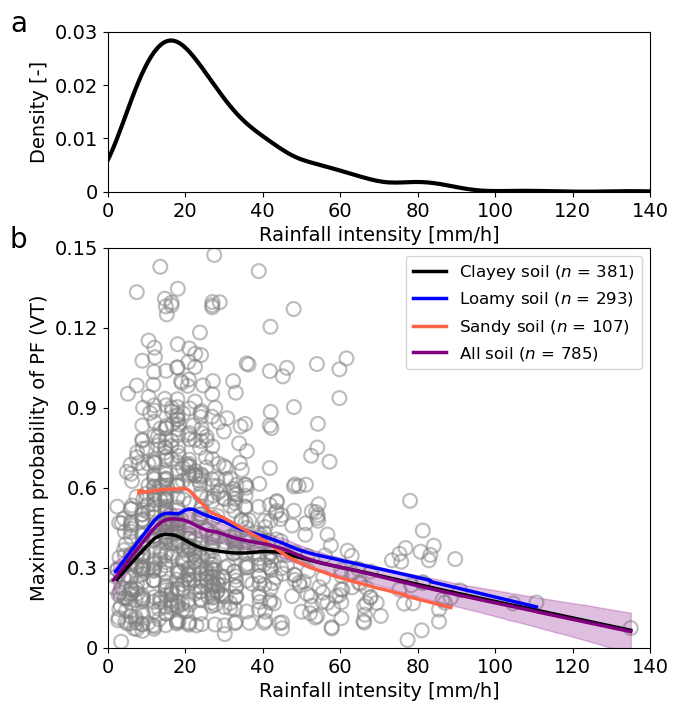

In [49]:
def last_fig_v(data, 
               type,
               by_texture = "clay",
               K = 1000, 
               lower_bound = 13, 
               upper_bound = 20,
               frac = 0.5) -> None:
    
    plt.style.use('default')
    fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [1.2, 3]}, figsize = (7, 8))
    all_data = data[["max_p_total", "peak_intensity_total"]].copy()
    split_required = data[["max_p_total", "peak_intensity_total", by_texture]].copy()
    x_all = all_data["peak_intensity_total"].to_numpy()
    y_all = all_data["max_p_total"].to_numpy()
    
    xgrid_all = np.linspace(np.nanmin(x_all), np.nanmax(x_all), num=K)
    smooths = np.stack([smooth(x_all, y_all, xgrid_all, sample_num=int(0.8*len(x_all)), frac=frac ) for k in range(K)]).T
    smooths_all = np.nanmean(smooths, axis=1)
    c25 = np.nanpercentile(smooths, 2.5, axis=1)
    c97 = np.nanpercentile(smooths, 97.5, axis=1)
    sns.kdeplot(data=all_data["peak_intensity_total"].dropna() * 6, ax=ax[0], c= "black", lw = 3)
    ax[0].set_ylabel("Density [-]", fontsize = 14)
    ax[0].set_xlabel("Rainfall intensity [mm/h]", fontsize = 14)
    ax[1].scatter(x_all * 6, y_all,
              alpha = 0.3, s = 100, 
              facecolor = "none", edgecolor = "grey", lw = 1.5)


    low_texture = split_required[split_required[by_texture] <= lower_bound].copy()
    intermediate = split_required[(split_required[by_texture] > lower_bound) & (split_required[by_texture] <= upper_bound)].copy()
    high = split_required[split_required[by_texture] > upper_bound].copy()
    texture_hub = [low_texture, intermediate, high]
    texture_label = ["Clayey soil", 
                     "Loamy soil",
                     "Sandy soil"]
    # if by_texture == "clay":
        
    texture_color = ["black", "blue", "tomato"]
    for j in range(3):
        info_texture = texture_hub[j]
        x_texture = info_texture["peak_intensity_total"].to_numpy()
        y_texture = info_texture["max_p_total"].to_numpy()
        xgrid_texture = np.linspace(np.nanmin(x_texture), np.nanmax(x_texture), num=K)
        smooths_texture = np.stack([smooth(x_texture, y_texture, xgrid_texture, sample_num=int(0.8*len(x_texture)), frac=frac) for k in range(K)]).T
        mean_texture = np.nanmean(smooths_texture, axis=1)
        c25_texture = np.nanpercentile(smooths_texture, 2.5, axis=1)
        c97_texture = np.nanpercentile(smooths_texture, 97.5, axis=1)
        lbj = texture_label[j]        
        numj = " ($n$ = " + str(info_texture.dropna().shape[0]) + ")"
      
        ax[1].plot(xgrid_texture*6, mean_texture, color=texture_color[j],label = lbj + numj, lw=2.5)
        # ax[1].fill_between(xgrid_texture*6, c25_texture,
        #              c25_texture, alpha=0.25, color = "purple")
    ax[1].fill_between(xgrid_all*6, c25,
                     c97, alpha=0.25, color = "purple")
    ax[1].plot(xgrid_all*6, smooths_all, color= "purple", lw = 2.5, label = f"All soil ($n$ = {all_data.dropna().shape[0]})")
    ax[1].set_xlabel(f"Rainfall intensity [mm/h]", fontsize = 14)
    ax[1].scatter(x_all * 6, y_all,
              alpha = 0.3, s = 100, 
              facecolor = "none", edgecolor = "grey", lw = 1.5)

    ax[1].legend(loc= "upper right", fontsize = 12)
    ax[1].set_ylim([0, 0.15])
    ax[1].set_ylabel("Maximum probability of PF (VT)", fontsize = 14)
    ax[1].tick_params("both", labelsize = 14)
    ax[0].text(-0.18, 1, "a", fontsize = 20, transform = ax[0].transAxes)
    ax[1].text(-0.18, 1, "b",fontsize = 20, transform = ax[1].transAxes)
    ax[0].tick_params("both", labelsize = 14)
    ax[0].set_xlim([0, 140])
    ax[0].set_yticks([0, 0.01, 0.02, 0.03])
    ax[0].set_yticklabels([str(i) for i in [0, 0.01, 0.02, 0.03]])
    ax[1].set_xlim([0, 140])
    ax[1].set_yticks([0, 0.03, 0.06, 0.09, 0.12, 0.15])
    ax[1].set_yticklabels([str(i) for i in [0, 0.3, 0.6, 0.9, 0.12, 0.15]])
    #    # clay, silty clay (silty clay loam, silt)
    #    # loamy soils (sandy loam, sand clay loam, silty loam) 
    #    # sandy soils (sand, loamy sand) 
        
last_fig_v(slopes_v, "VT", by_texture="clay", K = 1000, lower_bound = 20, upper_bound=40, frac=0.5)

/var/folders/2d/sdklzj254xq0zns12_lq844h0000gn/T/ipykernel_14966/3879423656.py:28: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax[row, col].scatter(fit_data[param], fit_data[yaxes_label[0]], facecolor = "none", lw =1.5,
/var/folders/2d/sdklzj254xq0zns12_lq844h0000gn/T/ipykernel_14966/3879423656.py:28: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax[row, col].scatter(fit_data[param], fit_data[yaxes_label[0]], facecolor = "none", lw =1.5,
/var/folders/2d/sdklzj254xq0zns12_lq844h0000gn/T/ipykernel_14966/3879423656.py:28: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax[row, col].scatter(fit_data[param], fit_data[yaxes_label[0]], facecolor = "none", lw =

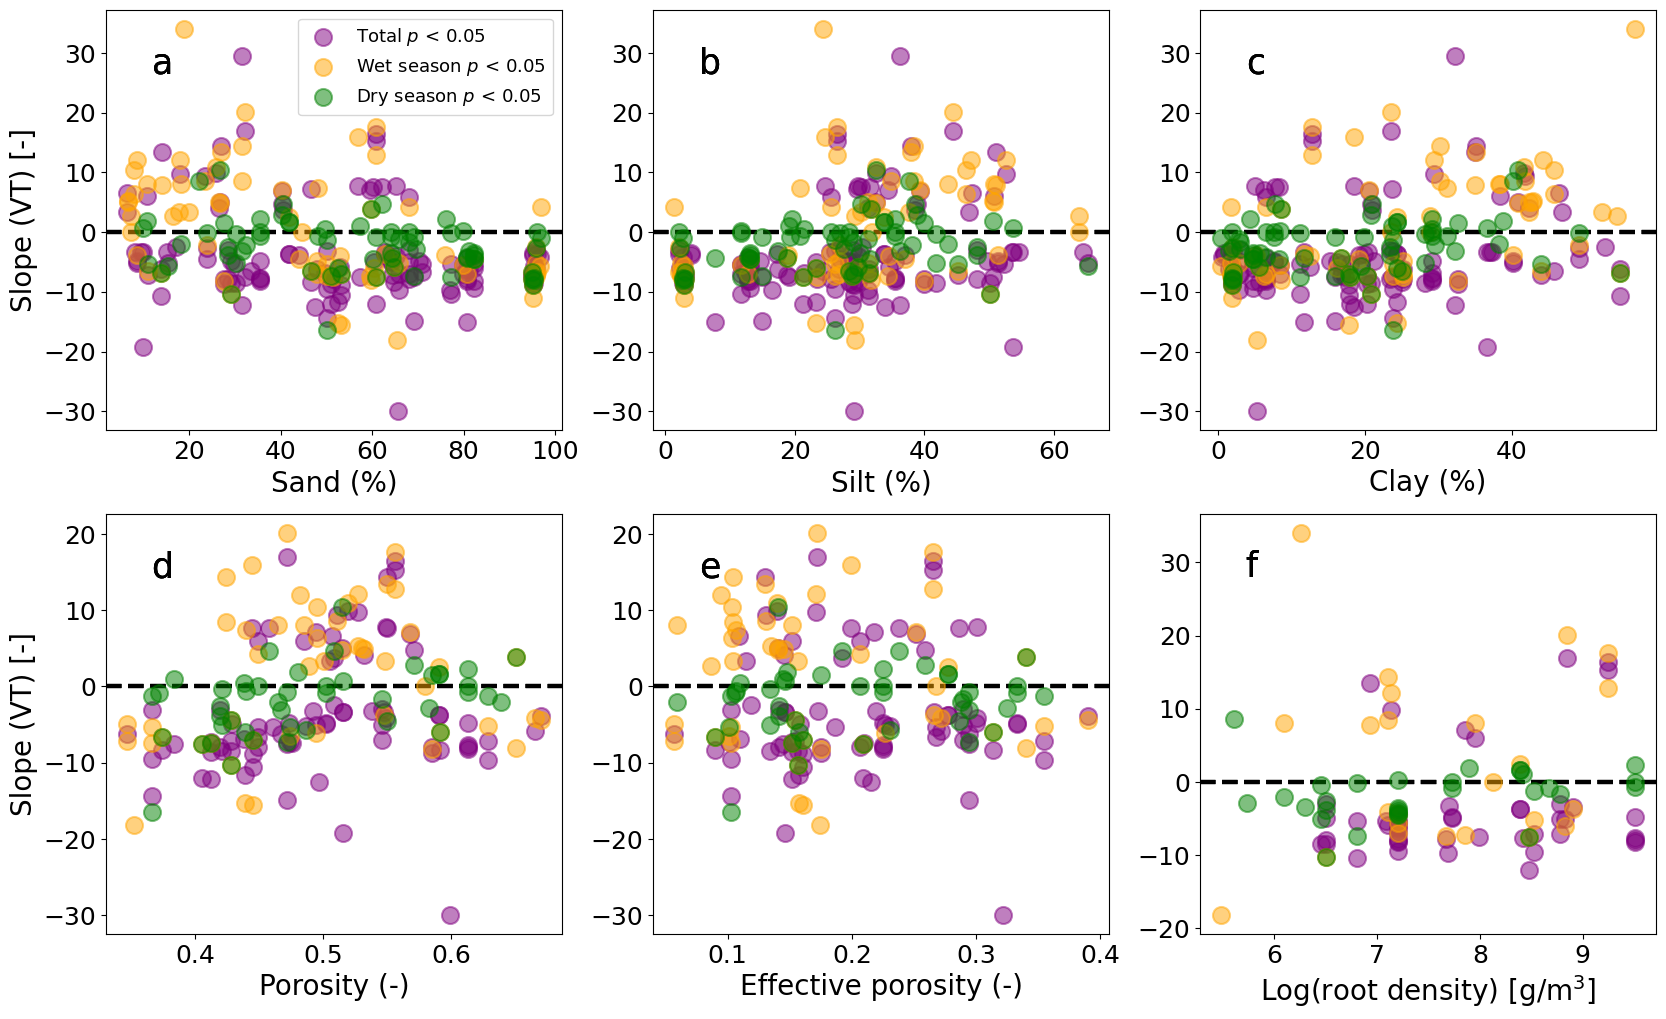

In [50]:
def V_render(data, type, frac = 0.5):
    data["log_density"] = np.log(data["root_density"])

    labels = ["Sand (%)", "Silt (%)", "Clay (%)", "Porosity (-)", "Effective porosity (-)", "Log(root density) [g/m$^3$]"]
    xes = ["sand", "silt", "clay", "porosity", "eff_porosity", "log_density"]
    data1 = data.loc[data["p_exp_total"] < 0.05, ["slope_exp_total"] + xes].copy()
    data_wet = data.loc[data["p_exp_wet"] < 0.05, ["slope_exp_wet"] + xes].copy()
    data_dry = data.loc[data["p_exp_dry"] < 0.05,["slope_exp_wet"] + xes].copy()
    num_fg = ["a", "b", "c", "d", "e", "f"]
    datahub= [data1, data_wet, data_dry]
    fig, ax = plt.subplots(2,3, figsize=(20,12))
    c = "red"
    if type == "NSR":
        c = "green"
    for j in np.arange(len(num_fg)):
            row, col = j//3, j%3
            param = xes[j]
            color = ["purple", "orange", "green"]
            label = ["Total", "Wet season", "Dry season"]
            for s in np.arange(len(datahub)):
                yaxes_label = [i for i in datahub[s].columns if "slope_exp_" in i]
                
                fit_data = datahub[s][yaxes_label + [param]].dropna().copy()
               
                # transform the data 
                lowess =  sm.nonparametric.lowess(fit_data[yaxes_label[0]],fit_data[param].to_numpy(),  frac=frac)
                ax[row, col].axhline(y = 0, c = "black", lw = 3, ls = "dashed", zorder  = 0)
                ax[row, col].scatter(fit_data[param], fit_data[yaxes_label[0]], facecolor = "none", lw =1.5,
                                    s= 150, label = f"{label[s]} $p$ < 0.05", alpha = 0.5, c = color[s])
            
                # ax[row, col].plot(lowess[:,0], lowess[:,1], c= color[s], lw = 4, label = "LOWESS fit")

                ax[row,col].set_xlabel(labels[j], fontsize = 20)
                ax[row,col].tick_params("both", labelsize = 18)
                ax[row,0].set_ylabel(f"Slope ({type}) [-]", fontsize = 20)
                ax[row, col].text(0.1, 0.85, num_fg[j], transform = ax[row, col].transAxes, fontsize = 25)
    ax[0,0].legend(fontsize = 13)
    # ax[0,0].legend(loc = "upper right", fontsize = 18)
V_render(slopes_v, "VT")

In [51]:
def visulize_bin_v(site, data):
    fig, ax = plt.subplots(2, 3, figsize = (16,10))
    data_v = data[site]
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#e377c2", 
              "#7f7f7f", "#bcbd22", "#17becf"]
    num = ["a", "b", "c", "d", "e", "f", "g", "h"]
    keys = sorted([i for i in data_v.keys()])
    for i in np.arange(len(keys)):
        row = i//3
        col = i%3
        print(row,col)
        cur_data = data_v[keys[i]]
        # at sensor level
        keys2 =sorted([i for i in cur_data.keys()])
        for k in np.arange(len(keys2)):
            sensor_info = cur_data[keys2[k]]
            data_info = sensor_info["data"]
           
            slope, intercept, p, depth = sensor_info["exp_info"]
            data_range = np.linspace(data_info["lower_bound"].min(),data_info["upper_bound"].max(), 100)
            exploted =  data_info.explode('soil_moisture')
            predict_p = np.exp(slope*data_range + intercept)
            ax[row,col].scatter(exploted["soil_moisture"], exploted["percent"], edgecolor = colors[k], facecolor = "none", s = 100)
            if p < 0.05:
                ax[row, col].plot(data_range, predict_p, ls = "solid", lw =3, label = f"Depth={int(depth)}cm (slope={slope:.2f})", c = colors[k])
            else:
                ax[row, col].plot(data_range, predict_p, ls = "dashed", lw =3, label = f"Depth={int(depth)}cm (slope={slope:.2f})", c = colors[k])
            ax[row,col].legend(loc= "upper right")
            ax[row, col].set_xlabel("Antecedent soil moisture (v/v)", fontsize = 15)
            if i == 0 or i == 3:
                ax[row, col].set_ylabel("Probability of PF occurence (VT)", fontsize = 15)
            ax[row, col].tick_params("both", labelsize = 12)
            ax[row, col].text(0.1, 0.9, keys[i], transform = ax[row, col].transAxes, fontsize = 16)
            ax[1,2].axis("off")
    fig.suptitle(site, x = 0.5, y = 0.92, fontsize = 20)
# visulize_bin_v("ORNL", detailsv)

In [52]:
def get_v_bin_by_precip():
    sites = FINAL_PF_RESULTS.keys()
    all_site_info = []
    sensor_scale = []
    for s in sites: 
        site_data =  FINAL_PF_RESULTS[s]  
        if s not in EXCLUDED_SITE and len(site_data) > 0:
            for plot_data in site_data:  
                if not plot_data.empty:
                    cal_v_cols = [j for j in plot_data.columns if j.split("_")[0] == "velocity"]
                    v_onset = [f"smOnset_50{j}" for j in  np.arange(1,len(cal_v_cols) + 1)]
                    v_before = [f"smBeforePrecip_50{j}" for j in  np.arange(1,len(cal_v_cols) + 1)]
                    plot_data[v_onset + v_before] = plot_data[v_onset + v_before].replace(-9999, np.nan)
                    global_min = plot_data.dropna(subset= v_onset + v_before, how = "all").loc[:,"stormPeakIntensity"].min()
                    global_max =  plot_data.dropna(subset=v_onset + v_before, how = "all").loc[:,"stormPeakIntensity"].max()
                    num_b = 20
                    # sensor specific interval of the events we succesfully extract soil moisture
                    # what fraction of it is 
                    sensor_scale = {}
                    for j in cal_v_cols:
                        ids = j.split("_")[-1]
                        data = plot_data[[f"smOnset_{ids}", f"sensor_depth_{ids}", f"PF_velocity_metric_{ids}",
                                        f"total_sand_{ids}", f"total_silt_{ids}", f"total_clay_{ids}",
                                        f"total_porosity_{ids}", f"total_eff_porosity_{ids}", f"root_density_{ids}",
                                        "stormPeakIntensity"]].copy()
                        # check if it is PF or not 
                        data = data[data[f"PF_velocity_metric_{ids}"]].copy()
                        data.columns = ["onset", "sensor_depth", "if_pf", 
                                        "sand", "silt", "clay", "porosity",
                                        "eff_porosity", "root_density",
                                        "storm_peak_intensity"]
                        # either there we have velocity metric or we can extract some data.
                        trigger_events = plot_data[(plot_data[f"smBeforePrecip_{ids}"].notna()) |
                                                (plot_data[f"smOnset_{ids}"].notna())].shape[0]
                        # just sesor data                    
                        if data["if_pf"].sum()> 0:
                            p_sensor = data["if_pf"].sum()/trigger_events
                            # sensor_scale.append([s, p_sensor, data["sensor_depth"].median()] +  
                            #                     data[["sensor_depth","sand", "silt", "clay", "porosity",
                            #                         "eff_porosity", "root_density",  "storm_peak_intensity"]].median(axis = 0).tolist())
                        regress_data = []
                        _, bin_edges = np.histogram(data["storm_peak_intensity"], bins=num_b, range= (global_min, global_max))
                        bin_intervals =  [[bin_edges[bi], bin_edges[bi + 1]] for bi in np.arange(len(bin_edges)-1)]
                        for it in np.arange(len(bin_intervals)):
                            lower_bound = bin_intervals[it][0]
                            upper_bound = bin_intervals[it][1]
                            mid_point = (upper_bound + lower_bound)/2
                            conditions =  (lower_bound <= data["storm_peak_intensity"]) & (data["storm_peak_intensity"] < upper_bound)
                            if it == len(bin_intervals):
                                conditions =  (lower_bound <= data["storm_peak_intensity"]) & (data["storm_peak_intensity"] <= upper_bound)
                            sensor_specific = data.loc[conditions, :].copy()
                            if sensor_specific["if_pf"].sum() > 0:
                                percent  = sensor_specific["if_pf"].sum()/trigger_events
                                # median where precip generates PF
                                peak_intensity = sensor_specific.loc[sensor_specific["if_pf"], "storm_peak_intensity"].median()
                                # median of soil and other params
                                soil_information = sensor_specific.loc[sensor_specific["if_pf"],
                                                                       ["sand", "silt", "clay", "porosity","eff_porosity", 
                                                                    "root_density", "onset"]].median(axis = 0)
                                regress_data.append([s, ids, percent, peak_intensity,  sensor_specific.loc[:,"sensor_depth"].median(), 
                                                    lower_bound, upper_bound, mid_point, 
                                                    sensor_specific.loc[sensor_specific["if_pf"], "storm_peak_intensity"].tolist()] + soil_information.tolist())
                        if len(regress_data) >= 5:
                            regress_data = pd.DataFrame(regress_data, columns= ["site", "plot", "percent",
                                                                                "peak_intensity", "sensor_depth",
                                                                                "lower_bound", "upper_bound", "mid_point",
                                                                                "precip","sand", "silt", "clay", "porosity",
                                                                                "eff_porosity", "root_density", 
                                                                                "soil_moisture"])
                            max_p = regress_data.loc[regress_data["percent"].idxmax(), [ "soil_moisture", "percent"]].tolist()
                            regress_data["log_p"] = np.log(regress_data["percent"])
                            # model1 y = ax + b
                            linear_modl = smf.ols(formula="percent ~ peak_intensity", data=regress_data)
                            res_linear = linear_modl.fit()
                            linear_modl_info = [res_linear.params["peak_intensity"],
                                                res_linear.pvalues["peak_intensity"],
                                                res_linear.rsquared]
                            # model2 fitting y = e^(ax + b) -> log(y) ~ ax + b  
                            # transform 
                            exp_modl = smf.ols(formula="log_p ~ peak_intensity", data=regress_data)
                            res_exp = exp_modl.fit()
                            normal_space_r2 = r2_score(regress_data["percent"], np.exp(res_exp.fittedvalues))
                                
                            exp_modl_info = [res_exp.params["peak_intensity"],
                                            res_exp.pvalues["peak_intensity"],
                                            res_exp.rsquared,
                                            normal_space_r2]
                            
                            non_reg_info = [regress_data.shape[0], 
                                            data["sensor_depth"].median(), 
                                            get_aridity(s), get_site_condition(s, "MAT"), 
                                            get_site_condition(s, "MAP"), s, f"{ids}"] 
                            over_all =  linear_modl_info + exp_modl_info + non_reg_info + regress_data[["sand", "silt", "clay", "porosity",
                                                                                                    "eff_porosity", "root_density"]].median(axis = 0).tolist() + max_p
                            
                            regress_data["fitted_exp"] = res_exp.fittedvalues
                            regress_data["slope_exp"] = res_exp.params["peak_intensity"]
                            regress_data["R2_exp"] = res_exp.rsquared
                            regress_data["p_exp"] = res_exp.pvalues["peak_intensity"]
                            sensor_scale["data"] = regress_data
                           
    all_site_info_pd = pd.DataFrame(all_site_info, columns=["slope_lm", "p_lm", "R2_lm",
                                                        "slope_exp", "p_exp", "R2_exp","R2_exp_norm", 
                                                        "num_data","sensor_depth", "aridity", "MAT", "MAP",
                                                        "site", "hvpos",
                                                        "sand", "silt", "clay", "porosity","eff_porosity", "root_density",
                                                        "soil_moisture", "max_p"])
    return all_site_info_pd

In [53]:
def nature_geo_fg2(d1_nsr, d2_v, type):
    if type == "peak_intensity":
        clabel1 = "Storm peak intensity "  
        clabel2 = " [mm/10min]"
    if type == "soil_moisture":
        clabel1 = "Antecedent soil moisture "
        clabel2 = " [v/v]"
    
    
    nsr_sg =  d1_nsr[d1_nsr['p_exp'] < 0.05].copy() 
    v_sg = d2_v[d2_v['p_exp'] < 0.05].copy()
  
    fig = plt.figure(constrained_layout=False, figsize=(10, 7 * 10 /9))
    gs1 = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[4.5,4.5],
                          height_ratios=[3,6])

    ax = fig.add_subplot(gs1[0, :])
    ax1 =fig.add_subplot(gs1[1, 0])
    ax2 = fig.add_subplot(gs1[1, 1])
    
    ax1.scatter(d1_nsr[type], d1_nsr["slope_exp"], edgecolors="grey", facecolor = "none",alpha = 0.8,
                label =  "$p$ > 0.05 ", s = 100)
    ax1.scatter(nsr_sg[type], nsr_sg["slope_exp"],alpha = 0.8, c = "green",
                label =  "$p$ < 0.05 ", s = 100)
    
    ax2.scatter(d2_v[type], d2_v["slope_exp"], edgecolors="grey", facecolor = "none",alpha = 0.8,
                label =  "$p$ > 0.05 ", s = 100)
    ax2.scatter(v_sg[type], v_sg["slope_exp"],alpha = 0.8, c = "red",
                label =  "$p$ < 0.05 ", s = 100)
    sns.kdeplot(data=nsr_sg['slope_exp'], label='NSR', shade=False, ax = ax, linewidth = 2.5, color = "green")
    sns.kdeplot(data=v_sg['slope_exp'], label='VT', shade=False, ax = ax, linewidth = 2.5, 
                color = "red", fill=False)
    ax.legend(fontsize =12, loc = "upper right")
    ax.set_xlabel("Slope [-]", fontsize = 14)
    ax.set_ylabel("Density", fontsize = 14)
    ax.tick_params("both", labelsize=12)
    ax1.tick_params("both", labelsize =12)
    ax1.set_xlabel(clabel1 + "(NSR)" + clabel2 , fontsize =14)
    ax1.set_ylabel("Slope [-]", fontsize =14)
    ax1.axhline(y = 0, color = "black", ls = "--", lw = 4)

    ax2.tick_params("both", labelsize =12)
    ax2.set_xlabel(clabel1 + "(VT)" + clabel2, fontsize =14)
    ax2.axhline(y = 0, color = "black", ls = "--", lw = 4)
    # ax1.set_ylim(min_y, max_y)
    # ax2.set_ylim(min_y, max_y)
    ax1.legend(fontsize=12, loc = "upper right")
    ax2.legend(fontsize=12, loc = "upper right")
    ax.text(0.9, 0.2, "a", transform = ax.transAxes, fontsize = 20)
    ax1.text(0.8, 0.2, "b", transform = ax1.transAxes, fontsize = 20)
    ax2.text(0.8, 0.2, "c", transform = ax2.transAxes, fontsize = 20)

nature_geo_fg2(nsr_by_sm, v_by_sm, "peak_intensity")
nature_geo_fg2(nsr_by_precip, v_by_precip, "soil_moisture")

NameError: name 'nsr_by_sm' is not defined

In [ ]:
def nature_geo_sup3(data, type):
    nsr_sg =  data[data['p_exp'] < 0.05].copy() 
    fig, ax = plt.subplots(1,3, figsize = (14, 4))
    labels = ["Aridity", "Mean annual temperature (°C)", "Mean annual precipitation (mm)"]
    cols = ["aridity", 'MAT', "MAP"]
    fig_num = ["a", "b", "c"]
    c = "red"
    if type == "NSR":
        c = "green"
    for i in np.arange(len(labels)):
        ax[i].scatter(data[cols[i]],data["slope_exp"], s = 100, edgecolor = "grey",
                      facecolor = "none",label = "$p$ > 0.05",alpha = 0.8)
        ax[i].scatter(nsr_sg[cols[i]],nsr_sg["slope_exp"], s = 100, c = c,
                      label = "$p$ < 0.05", alpha = 0.8)
        
        ax[i].tick_params("both", labelsize =12)
        ax[i].set_xlabel(labels[i],fontsize= 14)
        ax[i].tick_params("both", labelsize =12)
        ax[i].text(0.8, 0.2, fig_num[i], transform = ax[i].transAxes, fontsize = 20)
        ax[i].axhline(y = 0, color = "black", ls = "--", lw = 4)
        ax[i].legend(fontsize= 12, loc= "upper right")
        if i == 0:
            ax[i].set_ylabel(f"Slope ({type}) [-]",fontsize= 14)
# nature_geo_sup3(nsr_by_sm, "NSR")
# nature_geo_sup3(nsr_by_precip, "NSR")
nature_geo_sup3(slopes_v, "VT")
# nature_geo_sup3(v_by_precip, "VT")

In [ ]:
def nature_geo_sup4(data, type, frac = 0.5):
    data = data[data["p_exp"] < 0.05].copy()
    data["log_density"] = np.log(data["root_density"])
    labels = ["Sand (%)", "Silt (%)", "Clay (%)", "Porosity (-)", "Effective porosity (-)", "Log(root density) [g/m$^3$]"]
    xes = ["sand", "silt", "clay", "porosity", "eff_porosity", "log_density"]
    num_fg = ["a", "b", "c", "d", "e", "f"]
    fig, ax = plt.subplots(2,3, figsize=(20,12))
    c = "red"
    if type == "NSR":
        c = "green"
    for j in np.arange(len(num_fg)):
            
            row, col = j//3, j%3
            param = xes[j]
            fit_data = data[[param, "slope_exp"]].dropna().copy()
            num_data = fit_data.shape[0]
            # transform the data 
            # y_axis = StandardScaler().fit_transform(fit_data["slope_exp"].to_numpy().reshape(-1,1))
            lowess =  sm.nonparametric.lowess(fit_data["slope_exp"],fit_data[param].to_numpy(),  frac=frac)
            ax[row, col].axhline(y = 0, c = "black", lw = 3, ls = "dashed", zorder  = 0)
            ax[row, col].scatter(fit_data[param], fit_data["slope_exp"],c = c, facecolor = "none", lw =1.5,
                                s= 200, label = "$p$ < 0.05", alpha = 0.8)
           
            ax[row, col].plot(lowess[:,0], lowess[:,1], c= "blue", lw = 6, label = "LOWESS fit")

            ax[row,col].set_xlabel(labels[j], fontsize = 20)
            ax[row,col].tick_params("both", labelsize = 16)
            ax[row,0].set_ylabel(f"Slope ({type}) [-]", fontsize = 20)
            ax[row, col].text(0.2, 0.5, num_fg[j], transform = ax[row, col].transAxes, fontsize = 22)
            ax[row, col].text(0.1, 0.9, f"$n$ = {num_data}", transform = ax[row, col].transAxes, fontsize = 22)
    ax[0,0].legend(loc = "upper right", fontsize = 18)
# nature_geo_sup4(nsr_by_sm, "NSR")
# nature_geo_sup4(nsr_by_precip, "NSR")
# nature_geo_sup4(v_by_sm, "VT")
# nature_geo_sup4(v_by_precip, "VT")